In [1]:
import sys
import os

import pandas as pd
import numpy as np
from numpy import array
import numdifftools as ndt
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.linalg import block_diag

from datetime import datetime
from time import gmtime, strftime

from math import isclose
from copy import deepcopy
from itertools import product
import importlib
import time
import pickle
import random

import helper_funcs
import HHMM
import optimizor
import stoch_optimizor

# Load in Data

In [2]:
df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")
df_coarse = pd.read_csv("../../dat/Final_Data_Beth.csv")

df["stime"] = pd.to_datetime(df["stime"])
df["etime"] = pd.to_datetime(df["etime"])

# add dive duration
coarse_features = ['diveDuration']

df = df.merge(df_coarse[['divenum']+coarse_features],
              on = 'divenum',
              how = 'left')

for feature in coarse_features:
    df.loc[df.duplicated(['ID','divenum']),feature] = np.nan

df["w_low"] = np.log(df["w_low"])
df["w_high"] = np.log(df["w_high"])
#df['diveDuration'] = np.exp(df['diveDuration'])

df["delt_d"] = df["ad"].diff()
df["elev"] = -df["ad"]

df = df[df["ID"] == "D26"]#.iloc[0:5000]
df = df.reset_index()

jump_inds = df.index[~np.isnan(df["diveDuration"])].to_list()

/var/folders/1p/g1nbxjc540sd1x_r8wk3ljm00000gn/T/ipykernel_55366/4134700982.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../dat/Final_Data_Beth_fine.csv")


In [3]:
# populate a data object
data = []

initial_ts = [0]
final_ts = []

features = ['w_high','w_low']

means = {feature: df[feature].mean() for feature in features}
stds = {feature: df[feature].std() for feature in features}

for feature in features:#['aw1','aw2','aw3']:
    df[feature] = (df[feature] - means[feature])/stds[feature]

#for feature in ['diveDuration','w_low']:
#    df[feature] = df[feature]/stds[feature]

for t,row in enumerate(df.iterrows()):
    
    if t != 0 and df.iloc[t]["ID"] != df.iloc[t-1]["ID"]:
        final_ts.append(t-1)
        initial_ts.append(t)
     
    data.append({feature : row[1][feature] for feature in features})

final_ts.append(t)

initial_ts = np.array(initial_ts)
final_ts = np.array(final_ts)

print(initial_ts)
print(final_ts)

[0]
[9566]


In [4]:
data

[{'w_high': 2.1788752062285575, 'w_low': 3.625155821896476},
 {'w_high': 1.9372719755783183, 'w_low': 1.732943598044142},
 {'w_high': 1.5419194101666096, 'w_low': 1.7229235775610225},
 {'w_high': 0.9511873197460303, 'w_low': 0.6928125077731587},
 {'w_high': 0.944131953123355, 'w_low': 1.7888723876255275},
 {'w_high': 0.8939617566513325, 'w_low': 1.4735502558897982},
 {'w_high': 0.7798455281998519, 'w_low': 1.8394898243525837},
 {'w_high': 0.7757970894143906, 'w_low': 1.5207464144663507},
 {'w_high': 1.2010288513199752, 'w_low': 2.8870216916535005},
 {'w_high': -0.34394771011580116, 'w_low': 1.3034507223761964},
 {'w_high': 0.5392555801079354, 'w_low': 2.0527233352813483},
 {'w_high': 1.0939133560846597, 'w_low': 2.139243520702424},
 {'w_high': 1.3290221641765438, 'w_low': 1.4988639266398902},
 {'w_high': 1.6907327964249341, 'w_low': 1.5125135485137315},
 {'w_high': 1.7409062229150092, 'w_low': 1.1680734199966722},
 {'w_high': 2.0862393038664577, 'w_low': 1.206150323039343},
 {'w_high':

# Plot Data

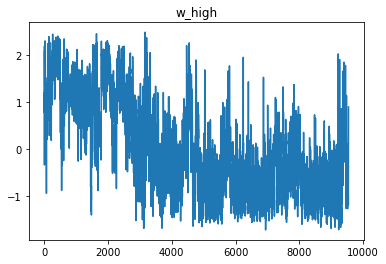

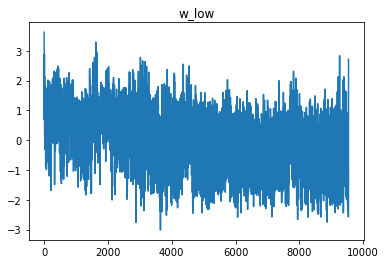

<AxesSubplot:>

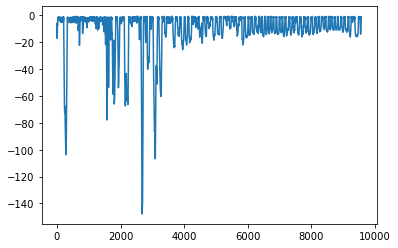

In [5]:
for feature in features:
    plt.plot([datum[feature] for datum in data if not np.isnan(datum[feature])])
    plt.title(feature)
    plt.show()
    
df["elev"].plot()

# Define HMM Parameters

In [6]:
len(data)
K = [2,3]
T = len(data)

In [7]:
share_params = []

'''
# share coarse scale dive duration
for feature in ['diveDuration']:
    for param in ['log_mu','log_sig']:
        for k0 in range(K[0]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0],
                                 "K_fine"  :[k1 for k1 in range(K[1])]})

# share fine scale acceleration
for feature in ['aw1','aw2','aw3']:
    for param in ['log_mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                "params" :[param],
                                "K_coarse":[k0 for k0 in range(K[0])],
                                "K_fine" :[k1]})
                                
# share autocorrelation for acceleration
for k1 in range(K[1]):
    share_params.append({"features":['aw1','aw2','aw3'],
                        "params"  :['logit_phi'],
                        "K_coarse":[k0 for k0 in range(K[0])],
                        "K_fine"  :[k1]})
'''

# share fine-scale params for "w_low"
for feature in ['w_low']:
    for param in ["mu","log_sig"]:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                "params"  :[param],
                                "K_coarse":[k0 for k0 in range(K[0])],
                                "K_fine"  :[k1]})
            
# share fine-scale params delta-d
for feature in ['w_high']:
    for param in ['mu','log_sig']:
        for k1 in range(K[1]):
            share_params.append({"features":[feature],
                                 "params"  :[param],
                                 "K_coarse":[k0 for k0 in range(K[0])],
                                 "K_fine"  :[k1]})

# Define Optimization Parameters

In [8]:
# parse command-line args
max_time = 60*60
id = 11

method_partialEs = [("control",0.0),
                    ("BFGS",0.0),
                    ("CG",0.0),
                    ("GD",0.0),
                    ("SAGA",0.0),
                    ("SAGA",0.5),
                    ("SAGA",1.0),
                    ("SVRG",0.0),
                    ("SVRG",0.5),
                    ("SVRG",1.0)]

rand_seed = [0,1,2,3,4,5,6,7,8,9]

# set methods
for i,settings0 in enumerate(product(rand_seed,method_partialEs)):
    if i == id:
        settings = settings0
        break

rand_seed = settings[0]
method = settings[1][0]
partial_E = settings[1][1]

random.seed(rand_seed)
np.random.seed(rand_seed)

print("method: %s" % method)
print("partial E_step: %.1f" % partial_E)
print("random seed: %d" % rand_seed)
print("max time : %.3f hours" % (max_time/3600))

# select parameters for optimization
num_epochs = 1000
tol = 1e-5
grad_tol = 1e-5

step_sizes = {"EM"  : [None,None],
              "CG"  : [None,None],
              "BFGS": [None,None],
              "GD"  : [0.005,0.005],
              "SGD" : [0.005,0.005],
              "SAG" : [0.005,0.005],
              "SVRG": [0.005,0.005],
              "SAGA": [0.005,0.005]}

### checks on optimization parameters ###
if partial_E > 0 and method in ["EM","BFGS","Nelder-Mead","CG"]:
    raise("partial_E not consistent with method")

method: BFGS
partial E_step: 0.0
random seed: 1
max time : 1.000 hours


# Initialize HMM

In [9]:
importlib.reload(HHMM)
importlib.reload(optimizor)
importlib.reload(stoch_optimizor)

### pick distributions ###
features = {'w_high'     : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : True},
           "w_low"       : {'f'           : 'normal',
                            'lower_bound' : None,
                            'upper_bound' : None,
                            'share_coarse': False,
                            'share_fine'  : True}}

# pick intial parameters
optim = stoch_optimizor.StochOptimizor(data,features,share_params,K)

### initial ts ###
optim.initial_ts = initial_ts
optim.final_ts = final_ts
optim.jump_inds = jump_inds

### lipschitz constants ###
if method == "control":
    optim.step_size = step_sizes["SAGA"]
    if not (step_sizes["SAGA"][0] is None):
        optim.L_theta = 1.0 / step_sizes["SAGA"][0] #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / step_sizes["SAGA"][1]
else:
    optim.step_size = step_sizes[method]
    if not (step_sizes[method][0] is None):
        optim.L_theta = 1.0 / (3.0 * step_sizes[method][0]) #* np.ones(optim.K_total)
        optim.L_eta = 1.0 / (3.0 * step_sizes[method][1])

optim.theta = \
[{'w_high': {'mu': array([-0.12255565, -0.96149786,  1.2586772 ]),
   'log_sig': array([-0.99814015, -1.27230921, -0.66817072])},
  'w_low': {'mu': array([ 0.14605137, -0.78533068,  0.78138527]),
   'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}},
 {'w_high': {'mu': array([-0.12255565, -0.96149786,  1.2586772 ]),
   'log_sig': array([-0.99814015, -1.27230921, -0.66817072])},
  'w_low': {'mu': array([ 0.14605137, -0.78533068,  0.78138527]),
   'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}}]

optim.eta = \
[array([[ 0. ,  -5.0],
        [-5.0,  0.  ]]),
 [array([[ 0.        , -2.63467712,  -2.52839288],
         [-2.81208007,  0.        , -2.3999472 ],
         [-2.42786391, -2.05214104,  0.        ]]),
  array([[  0.        ,  -2.34549301,  -2.45782255],
         [ -2.55640524,   0.        , -2.59733111],
         [ -2.53040783, -2.53370079,   0.        ]])]]

optim.eta0 = \
[array([0.        , 2.15480587]),
 [array([ 0.        , -3.33458184,  3.4987699 ]),
  array([0.        , 0.93641353, 0.65926559])]]

optim.get_log_Gamma(jump=False)
optim.get_log_Gamma(jump=True)
optim.get_log_delta()

# print initial parameters
print("initial theta:")
for theta_i in optim.theta:
    for feature in theta_i:
        print(feature)
        print(theta_i[feature])
        print("")
    print("")
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")

initial theta:
w_high
{'mu': array([-0.12255565, -0.96149786,  1.2586772 ]), 'log_sig': array([-0.99814015, -1.27230921, -0.66817072])}

w_low
{'mu': array([ 0.14605137, -0.78533068,  0.78138527]), 'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}


w_high
{'mu': array([-0.12255565, -0.96149786,  1.2586772 ]), 'log_sig': array([-0.99814015, -1.27230921, -0.66817072])}

w_low
{'mu': array([ 0.14605137, -0.78533068,  0.78138527]), 'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}



initial eta0:
[array([0.        , 2.15480587]), [array([ 0.        , -3.33458184,  3.4987699 ]), array([0.        , 0.93641353, 0.65926559])]]

initial eta:
[array([[ 0., -5.],
       [-5.,  0.]]), [array([[ 0.        , -2.63467712, -2.52839288],
       [-2.81208007,  0.        , -2.3999472 ],
       [-2.42786391, -2.05214104,  0.        ]]), array([[ 0.        , -2.34549301, -2.45782255],
       [-2.55640524,  0.        , -2.59733111],
       [-2.53040783, -2.53370079,  0.        ]])]]



# Train the HMM

In [10]:
grad_buffer = "none"
weight_buffer = "none"

# print initial parameters
print("initial theta:")
print(optim.theta)
print("")
print("initial eta0:")
print(optim.eta0)
print("")
print("initial eta:")
print(optim.eta)
print("")
print("parameter bounds:")
print(optim.param_bounds)
print("")
print("length of data:")
print(T)
print("")

# get optimal value via SAGA:
if method == "control":
    optim.train_HHMM_stoch(num_epochs=2*num_epochs,
                         max_time=max_time,
                         method="SAGA",
                         max_epochs=1,
                         partial_E=True,
                         tol=1e-4*tol,
                         grad_tol=1e-4*grad_tol,
                         record_like=True,
                         weight_buffer=weight_buffer,
                         grad_buffer=grad_buffer,
                         buffer_eps=1e-3)

elif partial_E == 0:
    optim.train_HHMM_stoch(num_epochs=num_epochs,
                          max_time=max_time,
                          method=method,
                          max_epochs=1,
                          partial_E=False,
                          tol=tol,
                          grad_tol=grad_tol,
                          record_like=True,
                          weight_buffer=weight_buffer,
                          grad_buffer=grad_buffer,
                          buffer_eps=1e-3)

elif partial_E == 0.5:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=1,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

elif partial_E == 1:
    if method in ["SGD","SAG","SVRG","SAGA"]:
        optim.train_HHMM_stoch(num_epochs=num_epochs,
                              max_time=max_time,
                              method=method,
                              max_epochs=10,
                              partial_E=True,
                              tol=tol,
                              grad_tol=grad_tol,
                              record_like=True,
                              weight_buffer=weight_buffer,
                              grad_buffer=grad_buffer,
                              buffer_eps=1e-3)

initial theta:
[{'w_high': {'mu': array([-0.12255565, -0.96149786,  1.2586772 ]), 'log_sig': array([-0.99814015, -1.27230921, -0.66817072])}, 'w_low': {'mu': array([ 0.14605137, -0.78533068,  0.78138527]), 'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}}, {'w_high': {'mu': array([-0.12255565, -0.96149786,  1.2586772 ]), 'log_sig': array([-0.99814015, -1.27230921, -0.66817072])}, 'w_low': {'mu': array([ 0.14605137, -0.78533068,  0.78138527]), 'log_sig': array([-0.22315451, -0.3949873 , -0.21918391])}}]

initial eta0:
[array([0.        , 2.15480587]), [array([ 0.        , -3.33458184,  3.4987699 ]), array([0.        , 0.93641353, 0.65926559])]]

initial eta:
[array([[ 0., -5.],
       [-5.,  0.]]), [array([[ 0.        , -2.63467712, -2.52839288],
       [-2.81208007,  0.        , -2.3999472 ],
       [-2.42786391, -2.05214104,  0.        ]]), array([[ 0.        , -2.34549301, -2.45782255],
       [-2.55640524,  0.        , -2.59733111],
       [-2.53040783, -2.53370079,  0.   

-17316.80122376998
starting epoch 3.0

0.017 hours elapsed

current log-likelihood:
-17316.80122376998

current parameters:
[{'w_high': {'mu': array([-0.06022558, -0.94780995,  1.26725189]), 'log_sig': array([-1.04456672, -1.27410271, -0.65905979])}, 'w_low': {'mu': array([ 0.10701437, -0.76102531,  0.87210144]), 'log_sig': array([-0.24113794, -0.4022478 , -0.29160197])}}, {'w_high': {'mu': array([-0.06022558, -0.94780995,  1.26725189]), 'log_sig': array([-1.04456672, -1.27410271, -0.65905979])}, 'w_low': {'mu': array([ 0.10701437, -0.76102531,  0.87210144]), 'log_sig': array([-0.24113794, -0.4022478 , -0.29160197])}}]
[array([[ 0.        , -4.99829971],
       [-5.00255009,  0.        ]]), [array([[ 0.        , -2.66380552, -2.52682598],
       [-2.80945798,  0.        , -2.40053202],
       [-2.62307523, -2.42519252,  0.        ]]), array([[ 0.        , -2.33823952, -2.67839275],
       [-2.52599721,  0.        , -2.97008115],
       [-2.50542573, -2.62128783,  0.        ]])]]
[array

-16924.54364008358
starting epoch 6.0

0.029 hours elapsed

current log-likelihood:
-16924.54364008358

current parameters:
[{'w_high': {'mu': array([-0.0062976 , -0.92805963,  1.30340142]), 'log_sig': array([-1.00321623, -1.2304474 , -0.68584061])}, 'w_low': {'mu': array([ 0.10082112, -0.71525272,  0.90679423]), 'log_sig': array([-0.20926655, -0.36129774, -0.3056209 ])}}, {'w_high': {'mu': array([-0.0062976 , -0.92805963,  1.30340142]), 'log_sig': array([-1.00321623, -1.2304474 , -0.68584061])}, 'w_low': {'mu': array([ 0.10082112, -0.71525272,  0.90679423]), 'log_sig': array([-0.20926655, -0.36129774, -0.3056209 ])}}]
[array([[ 0.        , -4.99008436],
       [-5.01482852,  0.        ]]), [array([[ 0.        , -2.80671437, -2.52178057],
       [-2.79651371,  0.        , -2.40354334],
       [-3.52690667, -4.14375639,  0.        ]]), array([[ 0.        , -2.3044706 , -3.69222906],
       [-2.4165056 ,  0.        , -4.68016639],
       [-2.38178751, -3.02946642,  0.        ]])]]
[array

-16780.709764953346
starting epoch 9.0

0.041 hours elapsed

current log-likelihood:
-16780.709764953346

current parameters:
[{'w_high': {'mu': array([-0.11498525, -0.95907098,  1.26688232]), 'log_sig': array([-0.97725503, -1.26314212, -0.68720433])}, 'w_low': {'mu': array([ 0.18289765, -0.77870175,  0.77354108]), 'log_sig': array([-0.20727398, -0.39103418, -0.21542194])}}, {'w_high': {'mu': array([-0.11498525, -0.95907098,  1.26688232]), 'log_sig': array([-0.97725503, -1.26314212, -0.68720433])}, 'w_low': {'mu': array([ 0.18289765, -0.77870175,  0.77354108]), 'log_sig': array([-0.20727398, -0.39103418, -0.21542194])}}]
[array([[ 0.        , -4.98120965],
       [-5.02624895,  0.        ]]), [array([[ 0.        , -2.95029873, -2.52236046],
       [-2.78324804,  0.        , -2.40656064],
       [-4.35643528, -5.72474686,  0.        ]]), array([[ 0.        , -2.27879484, -4.61683408],
       [-2.36067608,  0.        , -6.24845835],
       [-2.2581679 , -3.4118865 ,  0.        ]])]]
[arr

-16767.391100432957
starting epoch 12.0

0.054 hours elapsed

current log-likelihood:
-16767.391100432957

current parameters:
[{'w_high': {'mu': array([-0.12912445, -0.96624137,  1.25016145]), 'log_sig': array([-1.01833148, -1.28930064, -0.65673241])}, 'w_low': {'mu': array([ 0.14877403, -0.8001559 ,  0.77778574]), 'log_sig': array([-0.23494464, -0.41270451, -0.21745685])}}, {'w_high': {'mu': array([-0.12912445, -0.96624137,  1.25016145]), 'log_sig': array([-1.01833148, -1.28930064, -0.65673241])}, 'w_low': {'mu': array([ 0.14877403, -0.8001559 ,  0.77778574]), 'log_sig': array([-0.23494464, -0.41270451, -0.21745685])}}]
[array([[ 0.        , -4.97842585],
       [-5.02848539,  0.        ]]), [array([[ 0.        , -2.98501052, -2.52463723],
       [-2.77979637,  0.        , -2.40719809],
       [-4.50965462, -6.02080489,  0.        ]]), array([[ 0.        , -2.27840661, -4.77780847],
       [-2.36575241,  0.        , -6.53905126],
       [-2.23109352, -3.48847171,  0.        ]])]]
[ar

-16757.821665149437
starting epoch 15.0

0.068 hours elapsed

current log-likelihood:
-16757.821665149437

current parameters:
[{'w_high': {'mu': array([-0.12655034, -0.9676773 ,  1.25405881]), 'log_sig': array([-1.00820958, -1.29239421, -0.66408361])}, 'w_low': {'mu': array([ 0.11453134, -0.79298987,  0.80368588]), 'log_sig': array([-0.22492525, -0.40691241, -0.23194123])}}, {'w_high': {'mu': array([-0.12655034, -0.9676773 ,  1.25405881]), 'log_sig': array([-1.00820958, -1.29239421, -0.66408361])}, 'w_low': {'mu': array([ 0.11453134, -0.79298987,  0.80368588]), 'log_sig': array([-0.22492525, -0.40691241, -0.23194123])}}]
[array([[ 0.        , -4.97071391],
       [-5.03188715,  0.        ]]), [array([[ 0.        , -3.05809144, -2.53296856],
       [-2.77196   ,  0.        , -2.40816683],
       [-4.72455877, -6.45452132,  0.        ]]), array([[ 0.        , -2.29068598, -4.97393102],
       [-2.40091674,  0.        , -6.95661508],
       [-2.18239069, -3.61685715,  0.        ]])]]
[ar

-16734.506552903546
starting epoch 18.0

0.080 hours elapsed

current log-likelihood:
-16734.506552903546

current parameters:
[{'w_high': {'mu': array([-0.13341278, -0.97126843,  1.25897221]), 'log_sig': array([-0.97911247, -1.29202906, -0.669607  ])}, 'w_low': {'mu': array([ 0.13139843, -0.80164812,  0.78928412]), 'log_sig': array([-0.21917967, -0.40708188, -0.22387461])}}, {'w_high': {'mu': array([-0.13341278, -0.97126843,  1.25897221]), 'log_sig': array([-0.97911247, -1.29202906, -0.669607  ])}, 'w_low': {'mu': array([ 0.13139843, -0.80164812,  0.78928412]), 'log_sig': array([-0.21917967, -0.40708188, -0.22387461])}}]
[array([[ 0.        , -4.94559905],
       [-5.04010541,  0.        ]]), [array([[ 0.        , -3.27294073, -2.56437402],
       [-2.74816353,  0.        , -2.41059818],
       [-5.19716627, -7.45402988,  0.        ]]), array([[ 0.        , -2.34776233, -5.34508783],
       [-2.5491972 ,  0.        , -7.90198357],
       [-2.05171099, -3.94434403,  0.        ]])]]
[ar

-16722.222576359418
starting epoch 21.0

0.092 hours elapsed

current log-likelihood:
-16722.222576359418

current parameters:
[{'w_high': {'mu': array([-0.13292089, -0.9684767 ,  1.25403049]), 'log_sig': array([-1.00358387, -1.28560201, -0.66159158])}, 'w_low': {'mu': array([ 0.15739738, -0.80149104,  0.77638195]), 'log_sig': array([-0.23486906, -0.40956656, -0.21766382])}}, {'w_high': {'mu': array([-0.13292089, -0.9684767 ,  1.25403049]), 'log_sig': array([-1.00358387, -1.28560201, -0.66159158])}, 'w_low': {'mu': array([ 0.15739738, -0.80149104,  0.77638195]), 'log_sig': array([-0.23486906, -0.40956656, -0.21766382])}}]
[array([[ 0.        , -4.94119584],
       [-5.03513613,  0.        ]]), [array([[ 0.        , -3.25798261, -2.57868446],
       [-2.74779946,  0.        , -2.40941119],
       [-4.77979526, -6.71255989,  0.        ]]), array([[ 0.        , -2.38740908, -4.81708519],
       [-2.63482731,  0.        , -7.14733685],
       [-2.09235059, -3.80026044,  0.        ]])]]
[ar

-16720.14191465424
starting epoch 24.0

0.105 hours elapsed

current log-likelihood:
-16720.14191465424

current parameters:
[{'w_high': {'mu': array([-0.14255374, -0.9739017 ,  1.25208652]), 'log_sig': array([-0.99718819, -1.29658745, -0.66227977])}, 'w_low': {'mu': array([ 0.1286882 , -0.80628807,  0.78286914]), 'log_sig': array([-0.22899299, -0.4104262 , -0.21907461])}}, {'w_high': {'mu': array([-0.14255374, -0.9739017 ,  1.25208652]), 'log_sig': array([-0.99718819, -1.29658745, -0.66227977])}, 'w_low': {'mu': array([ 0.1286882 , -0.80628807,  0.78286914]), 'log_sig': array([-0.22899299, -0.4104262 , -0.21907461])}}]
[array([[ 0.        , -4.9382747 ],
       [-5.03464533,  0.        ]]), [array([[ 0.        , -3.26893043, -2.58369739],
       [-2.74601273,  0.        , -2.40928818],
       [-4.72166686, -6.62277003,  0.        ]]), array([[ 0.        , -2.39249407, -4.72775326],
       [-2.63733114,  0.        , -7.051112  ],
       [-2.09535221, -3.79192842,  0.        ]])]]
[arra

-16716.92217385784
starting epoch 27.0

0.118 hours elapsed

current log-likelihood:
-16716.92217385784

current parameters:
[{'w_high': {'mu': array([-0.15852969, -0.98291461,  1.25121561]), 'log_sig': array([-0.97378467, -1.31271382, -0.6605946 ])}, 'w_low': {'mu': array([ 0.11955065, -0.82769468,  0.77605625]), 'log_sig': array([-0.23295111, -0.42246479, -0.21678537])}}, {'w_high': {'mu': array([-0.15852969, -0.98291461,  1.25121561]), 'log_sig': array([-0.97378467, -1.31271382, -0.6605946 ])}, 'w_low': {'mu': array([ 0.11955065, -0.82769468,  0.77605625]), 'log_sig': array([-0.23295111, -0.42246479, -0.21678537])}}]
[array([[ 0.        , -4.92675236],
       [-5.03555536,  0.        ]]), [array([[ 0.        , -3.33181706, -2.59813533],
       [-2.73771545,  0.        , -2.40935957],
       [-4.71317663, -6.67688595,  0.        ]]), array([[ 0.        , -2.39155158, -4.64092685],
       [-2.57226751,  0.        , -7.08276219],
       [-2.08554928, -3.84663435,  0.        ]])]]
[arra

-16708.80087452816
starting epoch 30.0

0.131 hours elapsed

current log-likelihood:
-16708.80087452816

current parameters:
[{'w_high': {'mu': array([-0.16413391, -0.9872752 ,  1.24992681]), 'log_sig': array([-0.97587935, -1.32032547, -0.6589639 ])}, 'w_low': {'mu': array([ 0.12917294, -0.84132458,  0.77815688]), 'log_sig': array([-0.24501354, -0.43575437, -0.21836246])}}, {'w_high': {'mu': array([-0.16413391, -0.9872752 ,  1.24992681]), 'log_sig': array([-0.97587935, -1.32032547, -0.6589639 ])}, 'w_low': {'mu': array([ 0.12917294, -0.84132458,  0.77815688]), 'log_sig': array([-0.24501354, -0.43575437, -0.21836246])}}]
[array([[ 0.        , -4.89721583],
       [-5.03758262,  0.        ]]), [array([[ 0.        , -3.48142291, -2.63212462],
       [-2.71750889,  0.        , -2.409138  ],
       [-4.66591765, -6.77287595,  0.        ]]), array([[ 0.        , -2.36501045, -4.39631369],
       [-2.30676256,  0.        , -7.12396431],
       [-2.07862568, -3.97256377,  0.        ]])]]
[arra

-16707.244589498274
starting epoch 33.0

0.144 hours elapsed

current log-likelihood:
-16707.244589498274

current parameters:
[{'w_high': {'mu': array([-0.15779699, -0.98323816,  1.24854672]), 'log_sig': array([-0.99519771, -1.31164424, -0.6592162 ])}, 'w_low': {'mu': array([ 0.12653753, -0.8252344 ,  0.78007331]), 'log_sig': array([-0.23763493, -0.42404485, -0.21675991])}}, {'w_high': {'mu': array([-0.15779699, -0.98323816,  1.24854672]), 'log_sig': array([-0.99519771, -1.31164424, -0.6592162 ])}, 'w_low': {'mu': array([ 0.12653753, -0.8252344 ,  0.78007331]), 'log_sig': array([-0.23763493, -0.42404485, -0.21675991])}}]
[array([[ 0.        , -4.89500128],
       [-5.03794224,  0.        ]]), [array([[ 0.        , -3.4929857 , -2.63360958],
       [-2.71604489,  0.        , -2.40910282],
       [-4.67862734, -6.80784864,  0.        ]]), array([[ 0.        , -2.35892295, -4.40004508],
       [-2.3120152 ,  0.        , -7.15537489],
       [-2.076772  , -3.98733329,  0.        ]])]]
[ar

-16704.384931072043
starting epoch 36.0

0.156 hours elapsed

current log-likelihood:
-16704.384931072043

current parameters:
[{'w_high': {'mu': array([-0.15666316, -0.98168168,  1.24749048]), 'log_sig': array([-1.00130136, -1.30827601, -0.6580372 ])}, 'w_low': {'mu': array([ 0.11934014, -0.816047  ,  0.77199937]), 'log_sig': array([-0.22868185, -0.41334508, -0.21186502])}}, {'w_high': {'mu': array([-0.15666316, -0.98168168,  1.24749048]), 'log_sig': array([-1.00130136, -1.30827601, -0.6580372 ])}, 'w_low': {'mu': array([ 0.11934014, -0.816047  ,  0.77199937]), 'log_sig': array([-0.22868185, -0.41334508, -0.21186502])}}]
[array([[ 0.        , -4.8799992 ],
       [-5.03925493,  0.        ]]), [array([[ 0.        , -3.56400026, -2.64638677],
       [-2.70642091,  0.        , -2.40873452],
       [-4.67741708, -6.88686134,  0.        ]]), array([[ 0.        , -2.32668067, -4.31841453],
       [-2.34954434,  0.        , -7.20890736],
       [-2.07336447, -4.0535089 ,  0.        ]])]]
[ar

-16696.082395492816
starting epoch 39.0

0.169 hours elapsed

current log-likelihood:
-16696.082395492816

current parameters:
[{'w_high': {'mu': array([-0.15045235, -0.97757573,  1.24898712]), 'log_sig': array([-1.00197517, -1.30215948, -0.65879677])}, 'w_low': {'mu': array([ 0.1248821 , -0.81095368,  0.76711834]), 'log_sig': array([-0.22745998, -0.41009988, -0.21090964])}}, {'w_high': {'mu': array([-0.15045235, -0.97757573,  1.24898712]), 'log_sig': array([-1.00197517, -1.30215948, -0.65879677])}, 'w_low': {'mu': array([ 0.1248821 , -0.81095368,  0.76711834]), 'log_sig': array([-0.22745998, -0.41009988, -0.21090964])}}]
[array([[ 0.        , -4.8106288 ],
       [-5.04527664,  0.        ]]), [array([[ 0.        , -3.88933317, -2.7050157 ],
       [-2.66204763,  0.        , -2.40699554],
       [-4.6667297 , -7.24744751,  0.        ]]), array([[ 0.        , -2.17941358, -3.93692514],
       [-2.42915278,  0.        , -7.45235742],
       [-2.06356351, -4.3567626 ,  0.        ]])]]
[ar

-16694.333763327566
starting epoch 42.0

0.182 hours elapsed

current log-likelihood:
-16694.333763327566

current parameters:
[{'w_high': {'mu': array([-0.14772382, -0.97730476,  1.25134947]), 'log_sig': array([-0.99690541, -1.3030019 , -0.66193777])}, 'w_low': {'mu': array([ 0.13772175, -0.81876741,  0.78135778]), 'log_sig': array([-0.23875439, -0.42162955, -0.21802548])}}, {'w_high': {'mu': array([-0.14772382, -0.97730476,  1.25134947]), 'log_sig': array([-0.99690541, -1.3030019 , -0.66193777])}, 'w_low': {'mu': array([ 0.13772175, -0.81876741,  0.78135778]), 'log_sig': array([-0.23875439, -0.42162955, -0.21802548])}}]
[array([[ 0.        , -4.80187199],
       [-5.0461226 ,  0.        ]]), [array([[ 0.        , -3.92856352, -2.71132252],
       [-2.65651988,  0.        , -2.40676288],
       [-4.67215253, -7.30596034,  0.        ]]), array([[ 0.        , -2.17285784, -3.90512062],
       [-2.4185052 ,  0.        , -7.49687257],
       [-2.06288653, -4.39594692,  0.        ]])]]
[ar

-16693.34753310819
starting epoch 45.0

0.195 hours elapsed

current log-likelihood:
-16693.34753310819

current parameters:
[{'w_high': {'mu': array([-0.1472583 , -0.97742607,  1.25224816]), 'log_sig': array([-0.99517561, -1.30343272, -0.6632696 ])}, 'w_low': {'mu': array([ 0.13818522, -0.81936408,  0.78664612]), 'log_sig': array([-0.23975537, -0.42267128, -0.21977731])}}, {'w_high': {'mu': array([-0.1472583 , -0.97742607,  1.25224816]), 'log_sig': array([-0.99517561, -1.30343272, -0.6632696 ])}, 'w_low': {'mu': array([ 0.13818522, -0.81936408,  0.78664612]), 'log_sig': array([-0.23975537, -0.42267128, -0.21977731])}}]
[array([[ 0.        , -4.80387754],
       [-5.0454909 ,  0.        ]]), [array([[ 0.        , -3.90523155, -2.70610303],
       [-2.65852477,  0.        , -2.40656884],
       [-4.63611675, -7.22734085,  0.        ]]), array([[ 0.        , -2.24357868, -3.91496834],
       [-2.42151596,  0.        , -7.42432189],
       [-2.06829867, -4.36406702,  0.        ]])]]
[arra

-16691.636687856426
starting epoch 48.0

0.208 hours elapsed

current log-likelihood:
-16691.636687856426

current parameters:
[{'w_high': {'mu': array([-0.14620351, -0.97666058,  1.25281928]), 'log_sig': array([-0.99471365, -1.30140947, -0.66337002])}, 'w_low': {'mu': array([ 0.13512831, -0.81526208,  0.78293345]), 'log_sig': array([-0.23556753, -0.41800093, -0.21860115])}}, {'w_high': {'mu': array([-0.14620351, -0.97666058,  1.25281928]), 'log_sig': array([-0.99471365, -1.30140947, -0.66337002])}, 'w_low': {'mu': array([ 0.13512831, -0.81526208,  0.78293345]), 'log_sig': array([-0.23556753, -0.41800093, -0.21860115])}}]
[array([[ 0.        , -4.76627191],
       [-5.0491917 ,  0.        ]]), [array([[ 0.        , -4.06250369, -2.72836825],
       [-2.63491516,  0.        , -2.40558174],
       [-4.66038941, -7.47515312,  0.        ]]), array([[ 0.        , -2.35015748, -3.85422081],
       [-2.45382221,  0.        , -7.61521838],
       [-2.05322476, -4.52057686,  0.        ]])]]
[ar

-16691.517990433655
starting epoch 51.0

0.220 hours elapsed

current log-likelihood:
-16691.517990433655

current parameters:
[{'w_high': {'mu': array([-0.1465933 , -0.97674953,  1.25247524]), 'log_sig': array([-0.99498577, -1.30139163, -0.66276559])}, 'w_low': {'mu': array([ 0.13473494, -0.81524199,  0.78016358]), 'log_sig': array([-0.23511199, -0.41764204, -0.21779365])}}, {'w_high': {'mu': array([-0.1465933 , -0.97674953,  1.25247524]), 'log_sig': array([-0.99498577, -1.30139163, -0.66276559])}, 'w_low': {'mu': array([ 0.13473494, -0.81524199,  0.78016358]), 'log_sig': array([-0.23511199, -0.41764204, -0.21779365])}}]
[array([[ 0.        , -4.75746762],
       [-5.05036323,  0.        ]]), [array([[ 0.        , -4.10711373, -2.73550976],
       [-2.62894681,  0.        , -2.40549876],
       [-4.6873231 , -7.5737884 ,  0.        ]]), array([[ 0.        , -2.32427223, -3.84360274],
       [-2.4515521 ,  0.        , -7.69903148],
       [-2.04686705, -4.57050459,  0.        ]])]]
[ar

-16691.272436807543
starting epoch 54.0

0.234 hours elapsed

current log-likelihood:
-16691.272436807543

current parameters:
[{'w_high': {'mu': array([-0.14703354, -0.97702301,  1.25232708]), 'log_sig': array([-0.99479502, -1.3019596 , -0.66258655])}, 'w_low': {'mu': array([ 0.13476929, -0.81602075,  0.77952386]), 'log_sig': array([-0.23539714, -0.41818575, -0.21751052])}}, {'w_high': {'mu': array([-0.14703354, -0.97702301,  1.25232708]), 'log_sig': array([-0.99479502, -1.3019596 , -0.66258655])}, 'w_low': {'mu': array([ 0.13476929, -0.81602075,  0.77952386]), 'log_sig': array([-0.23539714, -0.41818575, -0.21751052])}}]
[array([[ 0.        , -4.74701213],
       [-5.05150741,  0.        ]]), [array([[ 0.        , -4.14352072, -2.73927842],
       [-2.62254442,  0.        , -2.40515834],
       [-4.68336624, -7.62588011,  0.        ]]), array([[ 0.        , -2.29687154, -3.84956026],
       [-2.44440978,  0.        , -7.73680881],
       [-2.04467093, -4.60466067,  0.        ]])]]
[ar

-16689.898552236835
starting epoch 57.0

0.246 hours elapsed

current log-likelihood:
-16689.898552236835

current parameters:
[{'w_high': {'mu': array([-0.14756147, -0.97756772,  1.25247671]), 'log_sig': array([-0.99371134, -1.3031438 , -0.66264064])}, 'w_low': {'mu': array([ 0.13484387, -0.8176402 ,  0.77891447]), 'log_sig': array([-0.23587566, -0.41933166, -0.21727514])}}, {'w_high': {'mu': array([-0.14756147, -0.97756772,  1.25247671]), 'log_sig': array([-0.99371134, -1.3031438 , -0.66264064])}, 'w_low': {'mu': array([ 0.13484387, -0.8176402 ,  0.77891447]), 'log_sig': array([-0.23587566, -0.41933166, -0.21727514])}}]
[array([[ 0.        , -4.68097239],
       [-5.05778108,  0.        ]]), [array([[ 0.        , -4.33712181, -2.75319994],
       [-2.58388312,  0.        , -2.40240004],
       [-4.57213672, -7.79247507,  0.        ]]), array([[ 0.        , -2.23883056, -3.90293972],
       [-2.4288556 ,  0.        , -7.8201194 ],
       [-2.04250357, -4.76239114,  0.        ]])]]
[ar

-16688.105540672143
starting epoch 60.0

0.259 hours elapsed

current log-likelihood:
-16688.105540672143

current parameters:
[{'w_high': {'mu': array([-0.14484786, -0.97674239,  1.25445914]), 'log_sig': array([-0.99182018, -1.30158927, -0.66441076])}, 'w_low': {'mu': array([ 0.1352481 , -0.81585747,  0.78213304]), 'log_sig': array([-0.23499974, -0.41832113, -0.21928615])}}, {'w_high': {'mu': array([-0.14484786, -0.97674239,  1.25445914]), 'log_sig': array([-0.99182018, -1.30158927, -0.66441076])}, 'w_low': {'mu': array([ 0.1352481 , -0.81585747,  0.78213304]), 'log_sig': array([-0.23499974, -0.41832113, -0.21928615])}}]
[array([[ 0.        , -4.55843223],
       [-5.06842606,  0.        ]]), [array([[ 0.        , -4.65567432, -2.76704952],
       [-2.51415074,  0.        , -2.39663592],
       [-4.28811063, -7.94920559,  0.        ]]), array([[ 0.        , -2.27179513, -4.04099399],
       [-2.44015171,  0.        , -7.83083037],
       [-2.04902172, -4.99530807,  0.        ]])]]
[ar

-16687.99031721416
starting epoch 63.0

0.272 hours elapsed

current log-likelihood:
-16687.99031721416

current parameters:
[{'w_high': {'mu': array([-0.14453105, -0.976503  ,  1.25452996]), 'log_sig': array([-0.99215884, -1.30104531, -0.66456229])}, 'w_low': {'mu': array([ 0.13502276, -0.81503203,  0.78283008]), 'log_sig': array([-0.23470402, -0.41772434, -0.21960069])}}, {'w_high': {'mu': array([-0.14453105, -0.976503  ,  1.25452996]), 'log_sig': array([-0.99215884, -1.30104531, -0.66456229])}, 'w_low': {'mu': array([ 0.13502276, -0.81503203,  0.78283008]), 'log_sig': array([-0.23470402, -0.41772434, -0.21960069])}}]
[array([[ 0.        , -4.57816465],
       [-5.06619598,  0.        ]]), [array([[ 0.        , -4.58867129, -2.760548  ],
       [-2.52613151,  0.        , -2.39734257],
       [-4.30281603, -7.85899491,  0.        ]]), array([[ 0.        , -2.30566966, -4.02562571],
       [-2.44844031,  0.        , -7.76710427],
       [-2.05154436, -4.93348995,  0.        ]])]]
[arra

-16687.93013024217
starting epoch 66.0

0.285 hours elapsed

current log-likelihood:
-16687.93013024217

current parameters:
[{'w_high': {'mu': array([-0.14498996, -0.97664579,  1.25429292]), 'log_sig': array([-0.99216014, -1.3012827 , -0.66432249])}, 'w_low': {'mu': array([ 0.13490322, -0.81535165,  0.78226631]), 'log_sig': array([-0.23479065, -0.41787916, -0.21934337])}}, {'w_high': {'mu': array([-0.14498996, -0.97664579,  1.25429292]), 'log_sig': array([-0.99216014, -1.3012827 , -0.66432249])}, 'w_low': {'mu': array([ 0.13490322, -0.81535165,  0.78226631]), 'log_sig': array([-0.23479065, -0.41787916, -0.21934337])}}]
[array([[ 0.        , -4.58338961],
       [-5.06504451,  0.        ]]), [array([[ 0.        , -4.56701623, -2.75780464],
       [-2.52950576,  0.        , -2.39758311],
       [-4.31851155, -7.83116979,  0.        ]]), array([[ 0.        , -2.30831598, -4.01375072],
       [-2.4480202 ,  0.        , -7.74657523],
       [-2.04918696, -4.91294825,  0.        ]])]]
[arra

-16687.566465768876
starting epoch 69.0

0.298 hours elapsed

current log-likelihood:
-16687.566465768876

current parameters:
[{'w_high': {'mu': array([-0.14645058, -0.97708196,  1.25350315]), 'log_sig': array([-0.99223682, -1.30200344, -0.66351002])}, 'w_low': {'mu': array([ 0.13456232, -0.81638214,  0.78040019]), 'log_sig': array([-0.23513152, -0.41841521, -0.21854351])}}, {'w_high': {'mu': array([-0.14645058, -0.97708196,  1.25350315]), 'log_sig': array([-0.99223682, -1.30200344, -0.66351002])}, 'w_low': {'mu': array([ 0.13456232, -0.81638214,  0.78040019]), 'log_sig': array([-0.23513152, -0.41841521, -0.21854351])}}]
[array([[ 0.        , -4.57178415],
       [-5.06119692,  0.        ]]), [array([[ 0.        , -4.55593304, -2.74781711],
       [-2.52506731,  0.        , -2.39731799],
       [-4.37548677, -7.78619583,  0.        ]]), array([[ 0.        , -2.31441837, -3.97537749],
       [-2.44575137,  0.        , -7.69222099],
       [-2.0269123 , -4.88867685,  0.        ]])]]
[ar

-16686.55919553918
starting epoch 72.0

0.311 hours elapsed

current log-likelihood:
-16686.55919553918

current parameters:
[{'w_high': {'mu': array([-0.1479379 , -0.97737091,  1.25238988]), 'log_sig': array([-0.99318057, -1.30250619, -0.66246347])}, 'w_low': {'mu': array([ 0.13417465, -0.81716332,  0.77858822]), 'log_sig': array([-0.23562318, -0.41887673, -0.21776012])}}, {'w_high': {'mu': array([-0.1479379 , -0.97737091,  1.25238988]), 'log_sig': array([-0.99318057, -1.30250619, -0.66246347])}, 'w_low': {'mu': array([ 0.13417465, -0.81716332,  0.77858822]), 'log_sig': array([-0.23562318, -0.41887673, -0.21776012])}}]
[array([[ 0.        , -4.41692924],
       [-5.05517835,  0.        ]]), [array([[ 0.        , -4.83120647, -2.72970304],
       [-2.44403688,  0.        , -2.39194156],
       [-4.49797192, -7.96247501,  0.        ]]), array([[ 0.        , -2.31193018, -3.91740066],
       [-2.44094351,  0.        , -7.6941474 ],
       [-1.92341183, -5.06673464,  0.        ]])]]
[arra

-16685.93886035578
starting epoch 75.0

0.324 hours elapsed

current log-likelihood:
-16685.93886035578

current parameters:
[{'w_high': {'mu': array([-0.14536543, -0.97643547,  1.25344017]), 'log_sig': array([-0.99424786, -1.3010098 , -0.66377659])}, 'w_low': {'mu': array([ 0.13470786, -0.81495914,  0.78240582]), 'log_sig': array([-0.23512119, -0.41778078, -0.21921216])}}, {'w_high': {'mu': array([-0.14536543, -0.97643547,  1.25344017]), 'log_sig': array([-0.99424786, -1.3010098 , -0.66377659])}, 'w_low': {'mu': array([ 0.13470786, -0.81495914,  0.78240582]), 'log_sig': array([-0.23512119, -0.41778078, -0.21921216])}}]
[array([[ 0.        , -4.254313  ],
       [-5.06141225,  0.        ]]), [array([[ 0.        , -5.23821064, -2.74396896],
       [-2.35283629,  0.        , -2.38570005],
       [-4.42404287, -8.33312791,  0.        ]]), array([[ 0.        , -2.28953084, -3.96620317],
       [-2.44252025,  0.        , -7.86755391],
       [-1.87404238, -5.38830243,  0.        ]])]]
[arra

-16685.91761134498
starting epoch 78.0

0.336 hours elapsed

current log-likelihood:
-16685.91761134498

current parameters:
[{'w_high': {'mu': array([-0.14522704, -0.97641874,  1.25357766]), 'log_sig': array([-0.99394456, -1.3009675 , -0.66379082])}, 'w_low': {'mu': array([ 0.13490153, -0.8150338 ,  0.78224106]), 'log_sig': array([-0.2351211 , -0.41785107, -0.21923068])}}, {'w_high': {'mu': array([-0.14522704, -0.97641874,  1.25357766]), 'log_sig': array([-0.99394456, -1.3009675 , -0.66379082])}, 'w_low': {'mu': array([ 0.13490153, -0.8150338 ,  0.78224106]), 'log_sig': array([-0.2351211 , -0.41785107, -0.21923068])}}]
[array([[ 0.        , -4.25903874],
       [-5.06171978,  0.        ]]), [array([[ 0.        , -5.23247561, -2.74613333],
       [-2.35504539,  0.        , -2.38576046],
       [-4.40709058, -8.33141405,  0.        ]]), array([[ 0.        , -2.28764819, -3.97679684],
       [-2.44212305,  0.        , -7.87066523],
       [-1.88511844, -5.38590437,  0.        ]])]]
[arra

-16685.7930325092
starting epoch 81.0

0.349 hours elapsed

current log-likelihood:
-16685.7930325092

current parameters:
[{'w_high': {'mu': array([-0.14509868, -0.97644617,  1.25379983]), 'log_sig': array([-0.99320833, -1.30093631, -0.66371932])}, 'w_low': {'mu': array([ 0.13527074, -0.8153181 ,  0.78161273]), 'log_sig': array([-0.23519927, -0.41809095, -0.21923991])}}, {'w_high': {'mu': array([-0.14509868, -0.97644617,  1.25379983]), 'log_sig': array([-0.99320833, -1.30093631, -0.66371932])}, 'w_low': {'mu': array([ 0.13527074, -0.8153181 ,  0.78161273]), 'log_sig': array([-0.23519927, -0.41809095, -0.21923991])}}]
[array([[ 0.        , -4.25638604],
       [-5.05915716,  0.        ]]), [array([[ 0.        , -5.23404907, -2.75162983],
       [-2.3529678 ,  0.        , -2.38519143],
       [-4.38267466, -8.34046847,  0.        ]]), array([[ 0.        , -2.28663775, -3.99586149],
       [-2.4409712 ,  0.        , -7.87488235],
       [-1.92296445, -5.38752342,  0.        ]])]]
[array(

-16685.28630658176
starting epoch 84.0

0.362 hours elapsed

current log-likelihood:
-16685.28630658176

current parameters:
[{'w_high': {'mu': array([-0.14554896, -0.97676998,  1.25385233]), 'log_sig': array([-0.99182884, -1.30124997, -0.66331415])}, 'w_low': {'mu': array([ 0.13550425, -0.81615612,  0.78028372]), 'log_sig': array([-0.23539409, -0.41863671, -0.21902678])}}, {'w_high': {'mu': array([-0.14554896, -0.97676998,  1.25385233]), 'log_sig': array([-0.99182884, -1.30124997, -0.66331415])}, 'w_low': {'mu': array([ 0.13550425, -0.81615612,  0.78028372]), 'log_sig': array([-0.23539409, -0.41863671, -0.21902678])}}]
[array([[ 0.        , -4.1455078 ],
       [-5.03709718,  0.        ]]), [array([[ 0.        , -5.40211924, -2.77169291],
       [-2.29135748,  0.        , -2.3787937 ],
       [-4.3840048 , -8.51305839,  0.        ]]), array([[ 0.        , -2.2949293 , -4.02077103],
       [-2.43945381,  0.        , -7.91066389],
       [-2.07084646, -5.49866589,  0.        ]])]]
[arra

-16684.95535370303
starting epoch 87.0

0.375 hours elapsed

current log-likelihood:
-16684.95535370303

current parameters:
[{'w_high': {'mu': array([-0.14654907, -0.97698193,  1.25296533]), 'log_sig': array([-0.99347454, -1.30171701, -0.66315727])}, 'w_low': {'mu': array([ 0.13426612, -0.81584155,  0.78154717]), 'log_sig': array([-0.23521132, -0.41817507, -0.21867544])}}, {'w_high': {'mu': array([-0.14654907, -0.97698193,  1.25296533]), 'log_sig': array([-0.99347454, -1.30171701, -0.66315727])}, 'w_low': {'mu': array([ 0.13426612, -0.81584155,  0.78154717]), 'log_sig': array([-0.23521132, -0.41817507, -0.21867544])}}]
[array([[ 0.        , -3.99848305],
       [-5.02224457,  0.        ]]), [array([[ 0.        , -5.65852024, -2.77339759],
       [-2.21211559,  0.        , -2.37261252],
       [-4.49014567, -8.73849652,  0.        ]]), array([[ 0.        , -2.3048342 , -3.96755571],
       [-2.44265791,  0.        , -7.96165048],
       [-2.07312872, -5.67324444,  0.        ]])]]
[arra

-16684.948536870255
starting epoch 90.0

0.388 hours elapsed

current log-likelihood:
-16684.948536870255

current parameters:
[{'w_high': {'mu': array([-0.14655292, -0.97698475,  1.2529701 ]), 'log_sig': array([-0.99354384, -1.30173012, -0.66321345])}, 'w_low': {'mu': array([ 0.13418522, -0.81581249,  0.78170102]), 'log_sig': array([-0.235226  , -0.41815957, -0.21872218])}}, {'w_high': {'mu': array([-0.14655292, -0.97698475,  1.2529701 ]), 'log_sig': array([-0.99354384, -1.30173012, -0.66321345])}, 'w_low': {'mu': array([ 0.13418522, -0.81581249,  0.78170102]), 'log_sig': array([-0.235226  , -0.41815957, -0.21872218])}}]
[array([[ 0.        , -4.01531363],
       [-5.02393181,  0.        ]]), [array([[ 0.        , -5.62620237, -2.7704357 ],
       [-2.22116834,  0.        , -2.37338381],
       [-4.49372548, -8.70846261,  0.        ]]), array([[ 0.        , -2.30575582, -3.96424121],
       [-2.44266381,  0.        , -7.95145102],
       [-2.05985315, -5.64962429,  0.        ]])]]
[ar

-16684.918413198644
starting epoch 93.0

0.401 hours elapsed

current log-likelihood:
-16684.918413198644

current parameters:
[{'w_high': {'mu': array([-0.1465082 , -0.97698218,  1.25302538]), 'log_sig': array([-0.99356741, -1.30173178, -0.66334199])}, 'w_low': {'mu': array([ 0.13406196, -0.81576547,  0.78196286]), 'log_sig': array([-0.23525265, -0.41814374, -0.21885604])}}, {'w_high': {'mu': array([-0.1465082 , -0.97698218,  1.25302538]), 'log_sig': array([-0.99356741, -1.30173178, -0.66334199])}, 'w_low': {'mu': array([ 0.13406196, -0.81576547,  0.78196286]), 'log_sig': array([-0.23525265, -0.41814374, -0.21885604])}}]
[array([[ 0.        , -4.035572  ],
       [-5.02495126,  0.        ]]), [array([[ 0.        , -5.58583009, -2.76550282],
       [-2.22995865,  0.        , -2.37375687],
       [-4.48924489, -8.67110495,  0.        ]]), array([[ 0.        , -2.3065934 , -3.96201625],
       [-2.44265677,  0.        , -7.93268029],
       [-2.04442096, -5.61860683,  0.        ]])]]
[ar

-16684.765158013164
starting epoch 96.0

0.413 hours elapsed

current log-likelihood:
-16684.765158013164

current parameters:
[{'w_high': {'mu': array([-0.14629507, -0.97697053,  1.25330648]), 'log_sig': array([-0.99344353, -1.30171739, -0.66379768])}, 'w_low': {'mu': array([ 0.13370527, -0.81563682,  0.78276012]), 'log_sig': array([-0.23526891, -0.41807816, -0.21931017])}}, {'w_high': {'mu': array([-0.14629507, -0.97697053,  1.25330648]), 'log_sig': array([-0.99344353, -1.30171739, -0.66379768])}, 'w_low': {'mu': array([ 0.13370527, -0.81563682,  0.78276012]), 'log_sig': array([-0.23526891, -0.41807816, -0.21931017])}}]
[array([[ 0.        , -4.04756725],
       [-5.02096063,  0.        ]]), [array([[ 0.        , -5.55927064, -2.74589362],
       [-2.21899306,  0.        , -2.37017738],
       [-4.45129311, -8.65198558,  0.        ]]), array([[ 0.        , -2.3076709 , -3.95949863],
       [-2.44297215,  0.        , -7.8842259 ],
       [-1.99169058, -5.58925754,  0.        ]])]]
[ar

-16684.580912655747
starting epoch 99.0

0.427 hours elapsed

current log-likelihood:
-16684.580912655747

current parameters:
[{'w_high': {'mu': array([-0.14618851, -0.9769948 ,  1.25355413]), 'log_sig': array([-0.99285385, -1.30171242, -0.66384884])}, 'w_low': {'mu': array([ 0.13384517, -0.81580016,  0.78251341]), 'log_sig': array([-0.23513578, -0.41812295, -0.21933861])}}, {'w_high': {'mu': array([-0.14618851, -0.9769948 ,  1.25355413]), 'log_sig': array([-0.99285385, -1.30171242, -0.66384884])}, 'w_low': {'mu': array([ 0.13384517, -0.81580016,  0.78251341]), 'log_sig': array([-0.23513578, -0.41812295, -0.21933861])}}]
[array([[ 0.        , -3.90974859],
       [-5.00155772,  0.        ]]), [array([[ 0.        , -5.82582781, -2.73487608],
       [-2.11623007,  0.        , -2.35756027],
       [-4.39445781, -8.916888  ,  0.        ]]), array([[ 0.        , -2.30356835, -3.9713055 ],
       [-2.44327807,  0.        , -7.91549084],
       [-1.98032891, -5.77058223,  0.        ]])]]
[ar

-16684.57092118837
starting epoch 102.0

0.439 hours elapsed

current log-likelihood:
-16684.57092118837

current parameters:
[{'w_high': {'mu': array([-0.14626714, -0.97701073,  1.2534842 ]), 'log_sig': array([-0.99282077, -1.30172761, -0.66370516])}, 'w_low': {'mu': array([ 0.13395539, -0.81587572,  0.78223015]), 'log_sig': array([-0.23512918, -0.41815957, -0.21919932])}}, {'w_high': {'mu': array([-0.14626714, -0.97701073,  1.2534842 ]), 'log_sig': array([-0.99282077, -1.30172761, -0.66370516])}, 'w_low': {'mu': array([ 0.13395539, -0.81587572,  0.78223015]), 'log_sig': array([-0.23512918, -0.41815957, -0.21919932])}}]
[array([[ 0.        , -3.88720298],
       [-5.00074497,  0.        ]]), [array([[ 0.        , -5.87218796, -2.74070811],
       [-2.10674966,  0.        , -2.35726341],
       [-4.40060585, -8.95887762,  0.        ]]), array([[ 0.        , -2.30304156, -3.97317192],
       [-2.44313337,  0.        , -7.93759979],
       [-1.99659679, -5.80652271,  0.        ]])]]
[arr

-16684.56524293585
starting epoch 105.0

0.452 hours elapsed

current log-likelihood:
-16684.56524293585

current parameters:
[{'w_high': {'mu': array([-0.14632311, -0.97703029,  1.25345137]), 'log_sig': array([-0.99280296, -1.30175604, -0.66366752])}, 'w_low': {'mu': array([ 0.13396075, -0.81592863,  0.78215107]), 'log_sig': array([-0.23515716, -0.41819276, -0.2191636 ])}}, {'w_high': {'mu': array([-0.14632311, -0.97703029,  1.25345137]), 'log_sig': array([-0.99280296, -1.30175604, -0.66366752])}, 'w_low': {'mu': array([ 0.13396075, -0.81592863,  0.78215107]), 'log_sig': array([-0.23515716, -0.41819276, -0.2191636 ])}}]
[array([[ 0.        , -3.89076167],
       [-5.00106977,  0.        ]]), [array([[ 0.        , -5.86717438, -2.74210949],
       [-2.10936975,  0.        , -2.35768226],
       [-4.40479827, -8.95325453,  0.        ]]), array([[ 0.        , -2.30337361, -3.97339878],
       [-2.4429513 ,  0.        , -7.93807497],
       [-2.00078192, -5.80346597,  0.        ]])]]
[arr

-16684.52978360304
starting epoch 108.0

0.464 hours elapsed

current log-likelihood:
-16684.52978360304

current parameters:
[{'w_high': {'mu': array([-0.14650058, -0.97709248,  1.25335095]), 'log_sig': array([-0.99275893, -1.30184762, -0.66355685])}, 'w_low': {'mu': array([ 0.13396991, -0.81609628,  0.78191598]), 'log_sig': array([-0.23524966, -0.41829909, -0.21905913])}}, {'w_high': {'mu': array([-0.14650058, -0.97709248,  1.25335095]), 'log_sig': array([-0.99275893, -1.30184762, -0.66355685])}, 'w_low': {'mu': array([ 0.13396991, -0.81609628,  0.78191598]), 'log_sig': array([-0.23524966, -0.41829909, -0.21905913])}}]
[array([[ 0.        , -3.90073005],
       [-4.99777481,  0.        ]]), [array([[ 0.        , -5.85510402, -2.74218218],
       [-2.10821876,  0.        , -2.35722958],
       [-4.41647856, -8.94154733,  0.        ]]), array([[ 0.        , -2.30431142, -3.97440473],
       [-2.44239314,  0.        , -7.92280337],
       [-2.01226179, -5.79164251,  0.        ]])]]
[arr

-16684.356128262803
starting epoch 111.0

0.476 hours elapsed

current log-likelihood:
-16684.356128262803

current parameters:
[{'w_high': {'mu': array([-0.14707316, -0.97728104,  1.25301453]), 'log_sig': array([-0.99275719, -1.30213397, -0.66321545])}, 'w_low': {'mu': array([ 0.13397178, -0.81659804,  0.78121453]), 'log_sig': array([-0.23554625, -0.41862208, -0.21873973])}}, {'w_high': {'mu': array([-0.14707316, -0.97728104,  1.25301453]), 'log_sig': array([-0.99275719, -1.30213397, -0.66321545])}, 'w_low': {'mu': array([ 0.13397178, -0.81659804,  0.78121453]), 'log_sig': array([-0.23554625, -0.41862208, -0.21873973])}}]
[array([[ 0.        , -3.92888393],
       [-4.96201139,  0.        ]]), [array([[ 0.        , -5.83282606, -2.71877249],
       [-2.0520194 ,  0.        , -2.34582337],
       [-4.45056466, -8.93331252,  0.        ]]), array([[ 0.        , -2.30682764, -3.97957921],
       [-2.44100422,  0.        , -7.77577148],
       [-2.04532774, -5.73738605,  0.        ]])]]
[a

-16683.74675376285
starting epoch 114.0

0.489 hours elapsed

current log-likelihood:
-16683.74675376285

current parameters:
[{'w_high': {'mu': array([-0.14764453, -0.97740662,  1.25260964]), 'log_sig': array([-0.99353087, -1.30237174, -0.66296041])}, 'w_low': {'mu': array([ 0.13380881, -0.81685028,  0.78085353]), 'log_sig': array([-0.23579659, -0.41880421, -0.21849612])}}, {'w_high': {'mu': array([-0.14764453, -0.97740662,  1.25260964]), 'log_sig': array([-0.99353087, -1.30237174, -0.66296041])}, 'w_low': {'mu': array([ 0.13380881, -0.81685028,  0.78085353]), 'log_sig': array([-0.23579659, -0.41880421, -0.21849612])}}]
[array([[ 0.        , -3.92673623],
       [-4.79141729,  0.        ]]), [array([[ 0.        , -5.92221354, -2.57116863],
       [-1.70937945,  0.        , -2.28080431],
       [-4.46860946, -9.1122355 ,  0.        ]]), array([[ 0.        , -2.30660079, -3.99766345],
       [-2.44208502,  0.        , -7.12244644],
       [-2.05768825, -5.61583833,  0.        ]])]]
[arr

-16683.560561272745
starting epoch 117.0

0.501 hours elapsed

current log-likelihood:
-16683.560561272745

current parameters:
[{'w_high': {'mu': array([-0.14704292, -0.97720162,  1.25296022]), 'log_sig': array([-0.99385598, -1.30208133, -0.66340535])}, 'w_low': {'mu': array([ 0.13367111, -0.81620962,  0.78191573]), 'log_sig': array([-0.23544105, -0.41839475, -0.21889677])}}, {'w_high': {'mu': array([-0.14704292, -0.97720162,  1.25296022]), 'log_sig': array([-0.99385598, -1.30208133, -0.66340535])}, 'w_low': {'mu': array([ 0.13367111, -0.81620962,  0.78191573]), 'log_sig': array([-0.23544105, -0.41839475, -0.21889677])}}]
[array([[ 0.        , -3.87371128],
       [-4.78034249,  0.        ]]), [array([[ 0.        , -6.01760292, -2.55141587],
       [-1.65565889,  0.        , -2.27242839],
       [-4.41709406, -9.22390364,  0.        ]]), array([[ 0.        , -2.30213511, -3.99778458],
       [-2.44442331,  0.        , -7.10857398],
       [-2.0041118 , -5.67365504,  0.        ]])]]
[a

-16683.53977873771
starting epoch 120.0

0.513 hours elapsed

current log-likelihood:
-16683.53977873771

current parameters:
[{'w_high': {'mu': array([-0.14687901, -0.97712755,  1.25304991]), 'log_sig': array([-0.99377315, -1.3019903 , -0.66346237])}, 'w_low': {'mu': array([ 0.13376247, -0.81612296,  0.78195723]), 'log_sig': array([-0.23537419, -0.41832819, -0.21892102])}}, {'w_high': {'mu': array([-0.14687901, -0.97712755,  1.25304991]), 'log_sig': array([-0.99377315, -1.3019903 , -0.66346237])}, 'w_low': {'mu': array([ 0.13376247, -0.81612296,  0.78195723]), 'log_sig': array([-0.23537419, -0.41832819, -0.21892102])}}]
[array([[ 0.        , -3.88292847],
       [-4.78759841,  0.        ]]), [array([[ 0.        , -5.98974597, -2.5613146 ],
       [-1.67262607,  0.        , -2.27513895],
       [-4.40899872, -9.19042252,  0.        ]]), array([[ 0.        , -2.30207219, -3.99529898],
       [-2.44494664,  0.        , -7.11653482],
       [-1.99729045, -5.6578471 ,  0.        ]])]]
[arr

-16683.420512498487
starting epoch 123.0

0.525 hours elapsed

current log-likelihood:
-16683.420512498487

current parameters:
[{'w_high': {'mu': array([-0.14639916, -0.97691409,  1.25329234]), 'log_sig': array([-0.99358008, -1.30170314, -0.66360296])}, 'w_low': {'mu': array([ 0.1340847 , -0.81584871,  0.78198917]), 'log_sig': array([-0.23521341, -0.41814304, -0.21895487])}}, {'w_high': {'mu': array([-0.14639916, -0.97691409,  1.25329234]), 'log_sig': array([-0.99358008, -1.30170314, -0.66360296])}, 'w_low': {'mu': array([ 0.1340847 , -0.81584871,  0.78198917]), 'log_sig': array([-0.23521341, -0.41814304, -0.21895487])}}]
[array([[ 0.        , -3.90141655],
       [-4.79034341,  0.        ]]), [array([[ 0.        , -5.94080394, -2.60682539],
       [-1.67360241,  0.        , -2.27563339],
       [-4.39349358, -9.14815926,  0.        ]]), array([[ 0.        , -2.30110059, -3.99284957],
       [-2.446383  ,  0.        , -7.08520134],
       [-1.97902356, -5.61682817,  0.        ]])]]
[a

-16683.10398524961
starting epoch 126.0

0.538 hours elapsed

current log-likelihood:
-16683.10398524961

current parameters:
[{'w_high': {'mu': array([-0.14572107, -0.97666675,  1.25363593]), 'log_sig': array([-0.99324456, -1.30132565, -0.66381124])}, 'w_low': {'mu': array([ 0.13466207, -0.81549958,  0.78197254]), 'log_sig': array([-0.23511003, -0.4179569 , -0.21890504])}}, {'w_high': {'mu': array([-0.14572107, -0.97666675,  1.25363593]), 'log_sig': array([-0.99324456, -1.30132565, -0.66381124])}, 'w_low': {'mu': array([ 0.13466207, -0.81549958,  0.78197254]), 'log_sig': array([-0.23511003, -0.4179569 , -0.21890504])}}]
[array([[ 0.        , -3.90143288],
       [-4.73443358,  0.        ]]), [array([[ 0.        , -5.97868377, -2.75569954],
       [-1.50848714,  0.        , -2.25172645],
       [-4.39606349, -9.28413265,  0.        ]]), array([[ 0.        , -2.29754183, -4.00707454],
       [-2.44781722,  0.        , -6.86492865],
       [-1.95072815, -5.57644649,  0.        ]])]]
[arr

-16683.01373745679
starting epoch 129.0

0.549 hours elapsed

current log-likelihood:
-16683.01373745679

current parameters:
[{'w_high': {'mu': array([-0.14620456, -0.97691415,  1.2533954 ]), 'log_sig': array([-0.99340769, -1.30164073, -0.66368676])}, 'w_low': {'mu': array([ 0.13440258, -0.81580653,  0.78196245]), 'log_sig': array([-0.2353456 , -0.41819312, -0.21882115])}}, {'w_high': {'mu': array([-0.14620456, -0.97691415,  1.2533954 ]), 'log_sig': array([-0.99340769, -1.30164073, -0.66368676])}, 'w_low': {'mu': array([ 0.13440258, -0.81580653,  0.78196245]), 'log_sig': array([-0.2353456 , -0.41819312, -0.21882115])}}]
[array([[ 0.        , -3.86744969],
       [-4.70023609,  0.        ]]), [array([[ 0.        , -6.09439172, -2.75691739],
       [-1.41601933,  0.        , -2.23791883],
       [-4.42212574, -9.44264715,  0.        ]]), array([[ 0.        , -2.29626067, -4.02052283],
       [-2.44579935,  0.        , -6.8088915 ],
       [-1.96356495, -5.63532276,  0.        ]])]]
[arr

-16683.011695126315
starting epoch 132.0

0.561 hours elapsed

current log-likelihood:
-16683.011695126315

current parameters:
[{'w_high': {'mu': array([-0.14625875, -0.97693476,  1.25337505]), 'log_sig': array([-0.99340595, -1.30166917, -0.66366629])}, 'w_low': {'mu': array([ 0.13437911, -0.81584909,  0.78191864]), 'log_sig': array([-0.23535822, -0.41821733, -0.21881141])}}, {'w_high': {'mu': array([-0.14625875, -0.97693476,  1.25337505]), 'log_sig': array([-0.99340595, -1.30166917, -0.66366629])}, 'w_low': {'mu': array([ 0.13437911, -0.81584909,  0.78191864]), 'log_sig': array([-0.23535822, -0.41821733, -0.21881141])}}]
[array([[ 0.        , -3.86619698],
       [-4.70153285,  0.        ]]), [array([[ 0.        , -6.0947778 , -2.74800719],
       [-1.41967324,  0.        , -2.23842974],
       [-4.42248252, -9.44102202,  0.        ]]), array([[ 0.        , -2.29658332, -4.01998709],
       [-2.44564245,  0.        , -6.81543617],
       [-1.96456616, -5.63716245,  0.        ]])]]
[a

-16682.998819442477
starting epoch 135.0

0.574 hours elapsed

current log-likelihood:
-16682.998819442477

current parameters:
[{'w_high': {'mu': array([-0.14637703, -0.97698082,  1.25333364]), 'log_sig': array([-0.99338651, -1.3017302 , -0.6636211 ])}, 'w_low': {'mu': array([ 0.13433898, -0.81595351,  0.78179834]), 'log_sig': array([-0.23539783, -0.41828265, -0.21879305])}}, {'w_high': {'mu': array([-0.14637703, -0.97698082,  1.25333364]), 'log_sig': array([-0.99338651, -1.3017302 , -0.6636211 ])}, 'w_low': {'mu': array([ 0.13433898, -0.81595351,  0.78179834]), 'log_sig': array([-0.23539783, -0.41828265, -0.21879305])}}]
[array([[ 0.        , -3.86493479],
       [-4.704484  ,  0.        ]]), [array([[ 0.        , -6.09259065, -2.72958585],
       [-1.42201811,  0.        , -2.23918439],
       [-4.4230767 , -9.44483597,  0.        ]]), array([[ 0.        , -2.29733739, -4.018579  ],
       [-2.44519461,  0.        , -6.83096886],
       [-1.96672341, -5.63792068,  0.        ]])]]
[a

-16682.927448819617
starting epoch 138.0

0.587 hours elapsed

current log-likelihood:
-16682.927448819617

current parameters:
[{'w_high': {'mu': array([-0.14670155, -0.97710522,  1.25322013]), 'log_sig': array([-0.99333678, -1.30189359, -0.66349442])}, 'w_low': {'mu': array([ 0.13424551, -0.81625051,  0.78142666]), 'log_sig': array([-0.23551771, -0.41847384, -0.21874636])}}, {'w_high': {'mu': array([-0.14670155, -0.97710522,  1.25322013]), 'log_sig': array([-0.99333678, -1.30189359, -0.66349442])}, 'w_low': {'mu': array([ 0.13424551, -0.81625051,  0.78142666]), 'log_sig': array([-0.23551771, -0.41847384, -0.21874636])}}]
[array([[ 0.        , -3.86858359],
       [-4.71503474,  0.        ]]), [array([[ 0.        , -6.07103569, -2.67433463],
       [-1.39961465,  0.        , -2.23977668],
       [-4.42424489, -9.49968485,  0.        ]]), array([[ 0.        , -2.29957806, -4.01335638],
       [-2.44380983,  0.        , -6.89170663],
       [-1.97362166, -5.62506037,  0.        ]])]]
[a

-16682.59596260728
starting epoch 141.0

0.600 hours elapsed

current log-likelihood:
-16682.59596260728

current parameters:
[{'w_high': {'mu': array([-0.14705614, -0.9772261 ,  1.25309257]), 'log_sig': array([-0.99333387, -1.30204878, -0.66333583])}, 'w_low': {'mu': array([ 0.13424658, -0.81662469,  0.78077817]), 'log_sig': array([-0.23569046, -0.41873939, -0.2187057 ])}}, {'w_high': {'mu': array([-0.14705614, -0.9772261 ,  1.25309257]), 'log_sig': array([-0.99333387, -1.30204878, -0.66333583])}, 'w_low': {'mu': array([ 0.13424658, -0.81662469,  0.78077817]), 'log_sig': array([-0.23569046, -0.41873939, -0.2187057 ])}}]
[array([[ 0.        , -3.91993012],
       [-4.74700054,  0.        ]]), [array([[ 0.        , -5.94124189, -2.57885835],
       [-1.17855077,  0.        , -2.23123205],
       [-4.4229001 , -9.87339469,  0.        ]]), array([[ 0.        , -2.30335119, -3.99795936],
       [-2.4413891 ,  0.        , -7.10191173],
       [-1.98896415, -5.51234391,  0.        ]])]]
[arr

-16681.86320317243
starting epoch 144.0

0.612 hours elapsed

current log-likelihood:
-16681.86320317243

current parameters:
[{'w_high': {'mu': array([-0.14584318, -0.97673051,  1.25354066]), 'log_sig': array([-0.9937518 , -1.3014001 , -0.66383819])}, 'w_low': {'mu': array([ 0.13483501, -0.81562167,  0.78162929]), 'log_sig': array([-0.23528958, -0.41814327, -0.21898006])}}, {'w_high': {'mu': array([-0.14584318, -0.97673051,  1.25354066]), 'log_sig': array([-0.9937518 , -1.3014001 , -0.66383819])}, 'w_low': {'mu': array([ 0.13483501, -0.81562167,  0.78162929]), 'log_sig': array([-0.23528958, -0.41814327, -0.21898006])}}]
[array([[ 0.        , -4.05841797],
       [-4.78233512,  0.        ]]), [array([[  0.        ,  -5.67501692,  -2.66125418],
       [ -0.43455448,   0.        ,  -2.18793717],
       [ -4.40924428, -11.02518449,   0.        ]]), array([[ 0.        , -2.30089228, -3.98398302],
       [-2.44405586,  0.        , -7.46644339],
       [-1.99075997, -5.21840039,  0.        ]

-16681.807239170168
starting epoch 147.0

0.624 hours elapsed

current log-likelihood:
-16681.807239170168

current parameters:
[{'w_high': {'mu': array([-0.14551244, -0.97660675,  1.25366882]), 'log_sig': array([-0.99381351, -1.30124894, -0.66401368])}, 'w_low': {'mu': array([ 0.13487542, -0.81530488,  0.78214805]), 'log_sig': array([-0.23515901, -0.4179231 , -0.21903095])}}, {'w_high': {'mu': array([-0.14551244, -0.97660675,  1.25366882]), 'log_sig': array([-0.99381351, -1.30124894, -0.66401368])}, 'w_low': {'mu': array([ 0.13487542, -0.81530488,  0.78214805]), 'log_sig': array([-0.23515901, -0.4179231 , -0.21903095])}}]
[array([[ 0.        , -4.05390443],
       [-4.74734235,  0.        ]]), [array([[  0.        ,  -5.70928267,  -2.7260874 ],
       [ -0.41577413,   0.        ,  -2.17876864],
       [ -4.40591149, -10.97416684,   0.        ]]), array([[ 0.        , -2.29843514, -3.99158618],
       [-2.44598259,  0.        , -7.29677838],
       [-1.98099854, -5.21382608,  0.       

-16681.806602024528
starting epoch 150.0

0.637 hours elapsed

current log-likelihood:
-16681.806602024528

current parameters:
[{'w_high': {'mu': array([-0.14547318, -0.97657886,  1.25366694]), 'log_sig': array([-0.99386151, -1.30119664, -0.66399271])}, 'w_low': {'mu': array([ 0.13493724, -0.81526281,  0.78204713]), 'log_sig': array([-0.23516437, -0.41791167, -0.2190232 ])}}, {'w_high': {'mu': array([-0.14547318, -0.97657886,  1.25366694]), 'log_sig': array([-0.99386151, -1.30119664, -0.66399271])}, 'w_low': {'mu': array([ 0.13493724, -0.81526281,  0.78204713]), 'log_sig': array([-0.23516437, -0.41791167, -0.2190232 ])}}]
[array([[ 0.        , -4.0543029 ],
       [-4.74778755,  0.        ]]), [array([[  0.        ,  -5.70606293,  -2.72284045],
       [ -0.43023202,   0.        ,  -2.17997067],
       [ -4.4066515 , -10.94960698,   0.        ]]), array([[ 0.        , -2.29830328, -3.99136991],
       [-2.44606304,  0.        , -7.29066237],
       [-1.98202048, -5.21400196,  0.       

-16681.80273298661
starting epoch 153.0

0.649 hours elapsed

current log-likelihood:
-16681.80273298661

current parameters:
[{'w_high': {'mu': array([-0.14536726, -0.97650978,  1.25366759]), 'log_sig': array([-0.99399022, -1.30107174, -0.66396196])}, 'w_low': {'mu': array([ 0.13506523, -0.8151434 ,  0.78185759]), 'log_sig': array([-0.23516499, -0.41787182, -0.21902393])}}, {'w_high': {'mu': array([-0.14536726, -0.97650978,  1.25366759]), 'log_sig': array([-0.99399022, -1.30107174, -0.66396196])}, 'w_low': {'mu': array([ 0.13506523, -0.8151434 ,  0.78185759]), 'log_sig': array([-0.23516499, -0.41787182, -0.21902393])}}]
[array([[ 0.        , -4.05332823],
       [-4.75098274,  0.        ]]), [array([[  0.        ,  -5.6953341 ,  -2.71707363],
       [ -0.45459364,   0.        ,  -2.18310322],
       [ -4.40802431, -10.91043649,   0.        ]]), array([[ 0.        , -2.29800295, -3.99085023],
       [-2.44638805,  0.        , -7.28080472],
       [-1.9841622 , -5.21399429,  0.        ]

-16681.780620384718
starting epoch 156.0

0.661 hours elapsed

current log-likelihood:
-16681.780620384718

current parameters:
[{'w_high': {'mu': array([-0.14504887, -0.97630539,  1.25367039]), 'log_sig': array([-0.99438191, -1.30070975, -0.66388188])}, 'w_low': {'mu': array([ 0.13543729, -0.81478724,  0.78133029]), 'log_sig': array([-0.23516282, -0.41775021, -0.21903086])}}, {'w_high': {'mu': array([-0.14504887, -0.97630539,  1.25367039]), 'log_sig': array([-0.99438191, -1.30070975, -0.66388188])}, 'w_low': {'mu': array([ 0.13543729, -0.81478724,  0.78133029]), 'log_sig': array([-0.23516282, -0.41775021, -0.21903086])}}]
[array([[ 0.        , -4.04021961],
       [-4.77115796,  0.        ]]), [array([[  0.        ,  -5.64158262,  -2.70094161],
       [ -0.52128956,   0.        ,  -2.1972496 ],
       [ -4.41226128, -10.81354033,   0.        ]]), array([[ 0.        , -2.29718481, -3.98947188],
       [-2.44741321,  0.        , -7.24866171],
       [-1.99047151, -5.2145596 ,  0.       

-16681.687464789287
starting epoch 159.0

0.674 hours elapsed

current log-likelihood:
-16681.687464789287

current parameters:
[{'w_high': {'mu': array([-0.14447238, -0.97594425,  1.25366954]), 'log_sig': array([-0.99512518, -1.3001066 , -0.66376392])}, 'w_low': {'mu': array([ 0.13611079, -0.81416914,  0.78051316]), 'log_sig': array([-0.23516644, -0.41753316, -0.21902205])}}, {'w_high': {'mu': array([-0.14447238, -0.97594425,  1.25366954]), 'log_sig': array([-0.99512518, -1.3001066 , -0.66376392])}, 'w_low': {'mu': array([ 0.13611079, -0.81416914,  0.78051316]), 'log_sig': array([-0.23516644, -0.41753316, -0.21902205])}}]
[array([[ 0.        , -3.946778  ],
       [-4.87732429,  0.        ]]), [array([[  0.        ,  -5.40788009,  -2.67506305],
       [ -0.61792071,   0.        ,  -2.25530273],
       [ -4.42146484, -10.74764004,   0.        ]]), array([[ 0.        , -2.29618484, -3.9878515 ],
       [-2.44935156,  0.        , -7.16993356],
       [-2.00173177, -5.2262048 ,  0.       

-16681.588229162022
starting epoch 162.0

0.686 hours elapsed

current log-likelihood:
-16681.588229162022

current parameters:
[{'w_high': {'mu': array([-0.14519803, -0.97642607,  1.25365188]), 'log_sig': array([-0.99429985, -1.3010305 , -0.66399607])}, 'w_low': {'mu': array([ 0.13527459, -0.81503874,  0.78197063]), 'log_sig': array([-0.23519675, -0.41782457, -0.2189612 ])}}, {'w_high': {'mu': array([-0.14519803, -0.97642607,  1.25365188]), 'log_sig': array([-0.99429985, -1.3010305 , -0.66399607])}, 'w_low': {'mu': array([ 0.13527459, -0.81503874,  0.78197063]), 'log_sig': array([-0.23519675, -0.41782457, -0.2189612 ])}}]
[array([[ 0.        , -3.85538018],
       [-4.95352804,  0.        ]]), [array([[  0.        ,  -5.28162025,  -2.71597362],
       [ -0.42676058,   0.        ,  -2.28073194],
       [ -4.41443514, -11.1489255 ,   0.        ]]), array([[ 0.        , -2.29932535, -3.9926299 ],
       [-2.4471851 ,  0.        , -7.19378897],
       [-1.98747027, -5.23807285,  0.       

-16681.587571929675
starting epoch 165.0

0.698 hours elapsed

current log-likelihood:
-16681.587571929675

current parameters:
[{'w_high': {'mu': array([-0.14525213, -0.97646134,  1.25365292]), 'log_sig': array([-0.99422974, -1.30109181, -0.66400891])}, 'w_low': {'mu': array([ 0.13521114, -0.81509832,  0.78205868]), 'log_sig': array([-0.23519446, -0.41784481, -0.21895815])}}, {'w_high': {'mu': array([-0.14525213, -0.97646134,  1.25365292]), 'log_sig': array([-0.99422974, -1.30109181, -0.66400891])}, 'w_low': {'mu': array([ 0.13521114, -0.81509832,  0.78205868]), 'log_sig': array([-0.23519446, -0.41784481, -0.21895815])}}]
[array([[ 0.        , -3.86501503],
       [-4.94417285,  0.        ]]), [array([[  0.        ,  -5.29888073,  -2.71877787],
       [ -0.41612552,   0.        ,  -2.27565448],
       [ -4.41363384, -11.15698067,   0.        ]]), array([[ 0.        , -2.29939666, -3.99289108],
       [-2.44699005,  0.        , -7.20002824],
       [-1.98656393, -5.2346071 ,  0.       

-16681.586574810433
starting epoch 168.0

0.710 hours elapsed

current log-likelihood:
-16681.586574810433

current parameters:
[{'w_high': {'mu': array([-0.14525658, -0.97646512,  1.25365471]), 'log_sig': array([-0.99422255, -1.30109932, -0.66401248])}, 'w_low': {'mu': array([ 0.1351992 , -0.8150993 ,  0.78208427]), 'log_sig': array([-0.23518625, -0.41784146, -0.21895535])}}, {'w_high': {'mu': array([-0.14525658, -0.97646512,  1.25365471]), 'log_sig': array([-0.99422255, -1.30109932, -0.66401248])}, 'w_low': {'mu': array([ 0.1351992 , -0.8150993 ,  0.78208427]), 'log_sig': array([-0.23518625, -0.41784146, -0.21895535])}}]
[array([[ 0.        , -3.87271449],
       [-4.93744493,  0.        ]]), [array([[  0.        ,  -5.30953583,  -2.71934461],
       [ -0.41719241,   0.        ,  -2.27354243],
       [ -4.41338267, -11.15107761,   0.        ]]), array([[ 0.        , -2.29932352, -3.99290083],
       [-2.44697145,  0.        , -7.20281426],
       [-1.98664603, -5.23414062,  0.       

-16681.58067900425
starting epoch 171.0

0.723 hours elapsed

current log-likelihood:
-16681.58067900425

current parameters:
[{'w_high': {'mu': array([-0.14526861, -0.9764751 ,  1.25365834]), 'log_sig': array([-0.99420796, -1.30112091, -0.66402239])}, 'w_low': {'mu': array([ 0.1351655 , -0.8150994 ,  0.78216252]), 'log_sig': array([-0.23516105, -0.41782939, -0.21894483])}}, {'w_high': {'mu': array([-0.14526861, -0.9764751 ,  1.25365834]), 'log_sig': array([-0.99420796, -1.30112091, -0.66402239])}, 'w_low': {'mu': array([ 0.1351655 , -0.8150994 ,  0.78216252]), 'log_sig': array([-0.23516105, -0.41782939, -0.21894483])}}]
[array([[ 0.        , -3.89698922],
       [-4.91674774,  0.        ]]), [array([[  0.        ,  -5.3357734 ,  -2.72082469],
       [ -0.42144476,   0.        ,  -2.27188597],
       [ -4.41283874, -11.14366517,   0.        ]]), array([[ 0.        , -2.2991603 , -3.9928457 ],
       [-2.44694223,  0.        , -7.21072922],
       [-1.98722212, -5.23948656,  0.        ]

-16681.552880558993
starting epoch 174.0

0.736 hours elapsed

current log-likelihood:
-16681.552880558993

current parameters:
[{'w_high': {'mu': array([-0.14529677, -0.97649491,  1.25365627]), 'log_sig': array([-0.99419852, -1.30116834, -0.66403649])}, 'w_low': {'mu': array([ 0.13509471, -0.81509535,  0.78233495]), 'log_sig': array([-0.23510848, -0.41779927, -0.21891463])}}, {'w_high': {'mu': array([-0.14529677, -0.97649491,  1.25365627]), 'log_sig': array([-0.99419852, -1.30116834, -0.66403649])}, 'w_low': {'mu': array([ 0.13509471, -0.81509535,  0.78233495]), 'log_sig': array([-0.23510848, -0.41779927, -0.21891463])}}]
[array([[ 0.        , -3.96819109],
       [-4.85960791,  0.        ]]), [array([[  0.        ,  -5.36840785,  -2.72326812],
       [ -0.43856635,   0.        ,  -2.29599398],
       [ -4.41274345, -11.18706677,   0.        ]]), array([[ 0.        , -2.2990883 , -3.99215398],
       [-2.44693355,  0.        , -7.22885475],
       [-1.99055323, -5.29353051,  0.       

-16681.456989180355
starting epoch 177.0

0.748 hours elapsed

current log-likelihood:
-16681.456989180355

current parameters:
[{'w_high': {'mu': array([-0.14528286, -0.97646883,  1.25359976]), 'log_sig': array([-0.99434163, -1.30113975, -0.66398652])}, 'w_low': {'mu': array([ 0.1351615 , -0.81507179,  0.78225278]), 'log_sig': array([-0.23515976, -0.41779535, -0.21889244])}}, {'w_high': {'mu': array([-0.14528286, -0.97646883,  1.25359976]), 'log_sig': array([-0.99434163, -1.30113975, -0.66398652])}, 'w_low': {'mu': array([ 0.1351615 , -0.81507179,  0.78225278]), 'log_sig': array([-0.23515976, -0.41779535, -0.21889244])}}]
[array([[ 0.        , -4.03551248],
       [-4.81803193,  0.        ]]), [array([[  0.        ,  -5.18847329,  -2.71727792],
       [ -0.47600714,   0.        ,  -2.46779882],
       [ -4.41914963, -11.57332154,   0.        ]]), array([[ 0.        , -2.30069917, -3.98928288],
       [-2.44723726,  0.        , -7.21994683],
       [-2.00060071, -5.55297212,  0.       

-16681.43738015274
starting epoch 180.0

0.761 hours elapsed

current log-likelihood:
-16681.43738015274

current parameters:
[{'w_high': {'mu': array([-0.14527701, -0.97645096,  1.25357704]), 'log_sig': array([-0.99437156, -1.30109053, -0.66394625])}, 'w_low': {'mu': array([ 0.13524693, -0.81509558,  0.78200556]), 'log_sig': array([-0.23524625, -0.41784401, -0.21891787])}}, {'w_high': {'mu': array([-0.14527701, -0.97645096,  1.25357704]), 'log_sig': array([-0.99437156, -1.30109053, -0.66394625])}, 'w_low': {'mu': array([ 0.13524693, -0.81509558,  0.78200556]), 'log_sig': array([-0.23524625, -0.41784401, -0.21891787])}}]
[array([[ 0.        , -3.96407009],
       [-4.86444408,  0.        ]]), [array([[  0.        ,  -5.11287112,  -2.71236963],
       [ -0.44937818,   0.        ,  -2.50269498],
       [ -4.4209339 , -11.70960194,   0.        ]]), array([[ 0.        , -2.30112497, -3.98950874],
       [-2.44726946,  0.        , -7.19241798],
       [-1.99871206, -5.60660205,  0.        ]

-16681.437287416764
starting epoch 183.0

0.774 hours elapsed

current log-likelihood:
-16681.437287416764

current parameters:
[{'w_high': {'mu': array([-0.14527634, -0.97645043,  1.25357629]), 'log_sig': array([-0.99437365, -1.30108783, -0.66394425])}, 'w_low': {'mu': array([ 0.13524784, -0.81509571,  0.78199692]), 'log_sig': array([-0.23524993, -0.41784588, -0.21892143])}}, {'w_high': {'mu': array([-0.14527634, -0.97645043,  1.25357629]), 'log_sig': array([-0.99437365, -1.30108783, -0.66394425])}, 'w_low': {'mu': array([ 0.13524784, -0.81509571,  0.78199692]), 'log_sig': array([-0.23524993, -0.41784588, -0.21892143])}}]
[array([[ 0.        , -3.96355226],
       [-4.86573664,  0.        ]]), [array([[  0.        ,  -5.115215  ,  -2.71237048],
       [ -0.44973539,   0.        ,  -2.49827546],
       [ -4.42100106, -11.69601184,   0.        ]]), array([[ 0.        , -2.30112268, -3.98950122],
       [-2.44725212,  0.        , -7.19214281],
       [-1.99887299, -5.59756172,  0.       

-16681.436806497335
starting epoch 186.0

0.786 hours elapsed

current log-likelihood:
-16681.436806497335

current parameters:
[{'w_high': {'mu': array([-0.14527468, -0.9764498 ,  1.25357532]), 'log_sig': array([-0.99437908, -1.30108501, -0.66394311])}, 'w_low': {'mu': array([ 0.13524557, -0.81509459,  0.78199628]), 'log_sig': array([-0.23525449, -0.41784634, -0.21892824])}}, {'w_high': {'mu': array([-0.14527468, -0.9764498 ,  1.25357532]), 'log_sig': array([-0.99437908, -1.30108501, -0.66394311])}, 'w_low': {'mu': array([ 0.13524557, -0.81509459,  0.78199628]), 'log_sig': array([-0.23525449, -0.41784634, -0.21892824])}}]
[array([[ 0.        , -3.96372522],
       [-4.86729437,  0.        ]]), [array([[  0.        ,  -5.11835553,  -2.71242602],
       [ -0.45163088,   0.        ,  -2.49406845],
       [ -4.42113217, -11.67954191,   0.        ]]), array([[ 0.        , -2.30112749, -3.98950371],
       [-2.44723432,  0.        , -7.19192303],
       [-1.99925412, -5.58639467,  0.       

-16681.433929907646
starting epoch 189.0

0.798 hours elapsed

current log-likelihood:
-16681.433929907646

current parameters:
[{'w_high': {'mu': array([-0.14526796, -0.97644737,  1.25357283]), 'log_sig': array([-0.99439744, -1.30107498, -0.66394049])}, 'w_low': {'mu': array([ 0.13523667, -0.81508925,  0.7819977 ]), 'log_sig': array([-0.23526876, -0.41784629, -0.21895198])}}, {'w_high': {'mu': array([-0.14526796, -0.97644737,  1.25357283]), 'log_sig': array([-0.99439744, -1.30107498, -0.66394049])}, 'w_low': {'mu': array([ 0.13523667, -0.81508925,  0.7819977 ]), 'log_sig': array([-0.23526876, -0.41784629, -0.21895198])}}]
[array([[ 0.        , -3.96494849],
       [-4.87405219,  0.        ]]), [array([[  0.        ,  -5.13031594,  -2.71261872],
       [ -0.46006701,   0.        ,  -2.48542103],
       [ -4.42164901, -11.63269088,   0.        ]]), array([[ 0.        , -2.30116013, -3.98950149],
       [-2.44718404,  0.        , -7.19092667],
       [-2.00069435, -5.54801075,  0.       

-16681.420601812006
starting epoch 192.0

0.810 hours elapsed

current log-likelihood:
-16681.420601812006

current parameters:
[{'w_high': {'mu': array([-0.14524746, -0.97644055,  1.25357131]), 'log_sig': array([-0.99443631, -1.30104703, -0.6639384 ])}, 'w_low': {'mu': array([ 0.13521141, -0.81507216,  0.78200546]), 'log_sig': array([-0.23530106, -0.41784278, -0.21901502])}}, {'w_high': {'mu': array([-0.14524746, -0.97644055,  1.25357131]), 'log_sig': array([-0.99443631, -1.30104703, -0.6639384 ])}, 'w_low': {'mu': array([ 0.13521141, -0.81507216,  0.78200546]), 'log_sig': array([-0.23530106, -0.41784278, -0.21901502])}}]
[array([[ 0.        , -3.97182686],
       [-4.89980693,  0.        ]]), [array([[  0.        ,  -5.16956267,  -2.71311234],
       [ -0.49443247,   0.        ,  -2.50080438],
       [ -4.42337156, -11.57607529,   0.        ]]), array([[ 0.        , -2.30132983, -3.98943062],
       [-2.44708287,  0.        , -7.18689793],
       [-2.00504684, -5.45205344,  0.       

-16681.354508928805
starting epoch 195.0

0.823 hours elapsed

current log-likelihood:
-16681.354508928805

current parameters:
[{'w_high': {'mu': array([-0.14521708, -0.97643515,  1.25360068]), 'log_sig': array([-0.99440789, -1.30101547, -0.66396589])}, 'w_low': {'mu': array([ 0.13516696, -0.81504387,  0.78203726]), 'log_sig': array([-0.23530247, -0.41782253, -0.21908323])}}, {'w_high': {'mu': array([-0.14521708, -0.97643515,  1.25360068]), 'log_sig': array([-0.99440789, -1.30101547, -0.66396589])}, 'w_low': {'mu': array([ 0.13516696, -0.81504387,  0.78203726]), 'log_sig': array([-0.23530247, -0.41782253, -0.21908323])}}]
[array([[ 0.        , -4.00292434],
       [-4.97775474,  0.        ]]), [array([[  0.        ,  -5.2563444 ,  -2.71366687],
       [ -0.60479373,   0.        ,  -2.73999887],
       [ -4.42738798, -11.89404427,   0.        ]]), array([[ 0.        , -2.30214259, -3.98889891],
       [-2.44715886,  0.        , -7.17402524],
       [-2.01293511, -5.36217715,  0.       

-16681.26339891311
starting epoch 198.0

0.834 hours elapsed

current log-likelihood:
-16681.26339891311

current parameters:
[{'w_high': {'mu': array([-0.14526847, -0.97647001,  1.25366854]), 'log_sig': array([-0.99416395, -1.30109997, -0.66403612])}, 'w_low': {'mu': array([ 0.13517025, -0.81509679,  0.7820909 ]), 'log_sig': array([-0.23518065, -0.41780937, -0.21894505])}}, {'w_high': {'mu': array([-0.14526847, -0.97647001,  1.25366854]), 'log_sig': array([-0.99416395, -1.30109997, -0.66403612])}, 'w_low': {'mu': array([ 0.13517025, -0.81509679,  0.7820909 ]), 'log_sig': array([-0.23518065, -0.41780937, -0.21894505])}}]
[array([[ 0.        , -4.06945809],
       [-5.09214689,  0.        ]]), [array([[  0.        ,  -5.25041115,  -2.71147978],
       [ -0.62782279,   0.        ,  -3.3842394 ],
       [ -4.43289167, -13.34534873,   0.        ]]), array([[ 0.        , -2.30444463, -3.98706462],
       [-2.4477291 ,  0.        , -7.15515397],
       [-2.01784046, -5.51656599,  0.        ]

-16681.26095558627
starting epoch 201.0

0.846 hours elapsed

current log-likelihood:
-16681.26095558627

current parameters:
[{'w_high': {'mu': array([-0.14522309, -0.97644171,  1.25366411]), 'log_sig': array([-0.99423588, -1.30105321, -0.66402672])}, 'w_low': {'mu': array([ 0.13521166, -0.81503873,  0.78204537]), 'log_sig': array([-0.23517637, -0.41778408, -0.21894795])}}, {'w_high': {'mu': array([-0.14522309, -0.97644171,  1.25366411]), 'log_sig': array([-0.99423588, -1.30105321, -0.66402672])}, 'w_low': {'mu': array([ 0.13521166, -0.81503873,  0.78204537]), 'log_sig': array([-0.23517637, -0.41778408, -0.21894795])}}]
[array([[ 0.        , -4.07486209],
       [-5.09311133,  0.        ]]), [array([[  0.        ,  -5.22660067,  -2.71027506],
       [ -0.58058102,   0.        ,  -3.44247382],
       [ -4.434119  , -13.56709136,   0.        ]]), array([[ 0.        , -2.30437568, -3.98675329],
       [-2.44798449,  0.        , -7.15220337],
       [-2.01921559, -5.5549007 ,  0.        ]

-16681.26069616819
starting epoch 204.0

0.858 hours elapsed

current log-likelihood:
-16681.26069616819

current parameters:
[{'w_high': {'mu': array([-0.14518141, -0.97641865,  1.25366295]), 'log_sig': array([-0.9942966 , -1.3010064 , -0.66402786])}, 'w_low': {'mu': array([ 0.13520911, -0.81498219,  0.78202222]), 'log_sig': array([-0.23517807, -0.41775901, -0.21899521])}}, {'w_high': {'mu': array([-0.14518141, -0.97641865,  1.25366295]), 'log_sig': array([-0.9942966 , -1.3010064 , -0.66402786])}, 'w_low': {'mu': array([ 0.13520911, -0.81498219,  0.78202222]), 'log_sig': array([-0.23517807, -0.41775901, -0.21899521])}}]
[array([[ 0.        , -4.07431302],
       [-5.087967  ,  0.        ]]), [array([[  0.        ,  -5.22514486,  -2.71019138],
       [ -0.57232233,   0.        ,  -3.43014718],
       [ -4.43426434, -13.55261459,   0.        ]]), array([[ 0.        , -2.30415066, -3.98669603],
       [-2.44819604,  0.        , -7.15217562],
       [-2.01966359, -5.55326435,  0.        ]

-16681.25915793443
starting epoch 207.0

0.870 hours elapsed

current log-likelihood:
-16681.25915793443

current parameters:
[{'w_high': {'mu': array([-0.14508776, -0.97636749,  1.25366201]), 'log_sig': array([-0.99442988, -1.30090364, -0.66403468])}, 'w_low': {'mu': array([ 0.1352016 , -0.81485701,  0.78197221]), 'log_sig': array([-0.23518007, -0.4177036 , -0.21910486])}}, {'w_high': {'mu': array([-0.14508776, -0.97636749,  1.25366201]), 'log_sig': array([-0.99442988, -1.30090364, -0.66403468])}, 'w_low': {'mu': array([ 0.1352016 , -0.81485701,  0.78197221]), 'log_sig': array([-0.23518007, -0.4177036 , -0.21910486])}}]
[array([[ 0.        , -4.07162254],
       [-5.0743865 ,  0.        ]]), [array([[  0.        ,  -5.22185247,  -2.71007364],
       [ -0.55592296,   0.        ,  -3.40809023],
       [ -4.43435031, -13.52868359,   0.        ]]), array([[ 0.        , -2.30362527, -3.98660989],
       [-2.44866908,  0.        , -7.15270214],
       [-2.02032525, -5.54809482,  0.        ]

-16681.2508732949
starting epoch 210.0

0.882 hours elapsed

current log-likelihood:
-16681.2508732949

current parameters:
[{'w_high': {'mu': array([-0.14483814, -0.97623191,  1.25366268]), 'log_sig': array([-0.99478042, -1.30063531, -0.66405773])}, 'w_low': {'mu': array([ 0.13519041, -0.81452959,  0.78184356]), 'log_sig': array([-0.23518312, -0.41755984, -0.2193897 ])}}, {'w_high': {'mu': array([-0.14483814, -0.97623191,  1.25366268]), 'log_sig': array([-0.99478042, -1.30063531, -0.66405773])}, 'w_low': {'mu': array([ 0.13519041, -0.81452959,  0.78184356]), 'log_sig': array([-0.23518312, -0.41755984, -0.2193897 ])}}]
[array([[ 0.        , -4.05785417],
       [-5.02749115,  0.        ]]), [array([[  0.        ,  -5.21231047,  -2.70981496],
       [ -0.51795155,   0.        ,  -3.39299439],
       [ -4.43363093, -13.55143176,   0.        ]]), array([[ 0.        , -2.30206684, -3.98658105],
       [-2.44987053,  0.        , -7.15631039],
       [-2.02074184, -5.52851797,  0.        ]])

-16681.21398770251
starting epoch 213.0

0.894 hours elapsed

current log-likelihood:
-16681.21398770251

current parameters:
[{'w_high': {'mu': array([-0.14447137, -0.97603646,  1.25368236]), 'log_sig': array([-0.99526454, -1.30027141, -0.66411411])}, 'w_low': {'mu': array([ 0.13523706, -0.81408827,  0.78168702]), 'log_sig': array([-0.23517781, -0.41737217, -0.21974824])}}, {'w_high': {'mu': array([-0.14447137, -0.97603646,  1.25368236]), 'log_sig': array([-0.99526454, -1.30027141, -0.66411411])}, 'w_low': {'mu': array([ 0.13523706, -0.81408827,  0.78168702]), 'log_sig': array([-0.23517781, -0.41737217, -0.21974824])}}]
[array([[ 0.        , -3.99764292],
       [-4.89817536,  0.        ]]), [array([[  0.        ,  -5.19351219,  -2.70971674],
       [ -0.49630609,   0.        ,  -3.66004639],
       [ -4.42670591, -14.16474551,   0.        ]]), array([[ 0.        , -2.29876804, -3.98780517],
       [-2.45123663,  0.        , -7.17523232],
       [-2.01285996, -5.46271137,  0.        ]

-16681.15039603376
starting epoch 216.0

0.907 hours elapsed

current log-likelihood:
-16681.15039603376

current parameters:
[{'w_high': {'mu': array([-0.14505493, -0.9763629 ,  1.25373172]), 'log_sig': array([-0.99436186, -1.30097925, -0.66412292])}, 'w_low': {'mu': array([ 0.13543626, -0.81495398,  0.78207803]), 'log_sig': array([-0.23513736, -0.41776549, -0.21891382])}}, {'w_high': {'mu': array([-0.14505493, -0.9763629 ,  1.25373172]), 'log_sig': array([-0.99436186, -1.30097925, -0.66412292])}, 'w_low': {'mu': array([ 0.13543626, -0.81495398,  0.78207803]), 'log_sig': array([-0.23513736, -0.41776549, -0.21891382])}}]
[array([[ 0.        , -3.94488158],
       [-4.86424027,  0.        ]]), [array([[  0.        ,  -5.19680174,  -2.71093066],
       [ -0.64178052,   0.        ,  -4.93119451],
       [ -4.41451528, -16.76398164,   0.        ]]), array([[ 0.        , -2.30001654, -3.99096749],
       [-2.44749527,  0.        , -7.19676716],
       [-1.99023874, -5.4401817 ,  0.        ]

-16681.13884568026
starting epoch 219.0

0.921 hours elapsed

current log-likelihood:
-16681.13884568026

current parameters:
[{'w_high': {'mu': array([-0.14518453, -0.97643098,  1.2537226 ]), 'log_sig': array([-0.9941999 , -1.30109452, -0.66409718])}, 'w_low': {'mu': array([ 0.13541705, -0.8151093 ,  0.78209766]), 'log_sig': array([-0.23515786, -0.41783508, -0.2188052 ])}}, {'w_high': {'mu': array([-0.14518453, -0.97643098,  1.2537226 ]), 'log_sig': array([-0.9941999 , -1.30109452, -0.66409718])}, 'w_low': {'mu': array([ 0.13541705, -0.8151093 ,  0.78209766]), 'log_sig': array([-0.23515786, -0.41783508, -0.2188052 ])}}]
[array([[ 0.        , -3.97117154],
       [-4.91208961,  0.        ]]), [array([[  0.        ,  -5.20618887,  -2.70981139],
       [ -0.63722426,   0.        ,  -6.19420946],
       [ -4.41863675, -19.60079407,   0.        ]]), array([[ 0.        , -2.30148243, -3.99024179],
       [-2.44700428,  0.        , -7.1860046 ],
       [-1.99647163, -5.45535997,  0.        ]

-16681.13474994467
starting epoch 222.0

0.934 hours elapsed

current log-likelihood:
-16681.13474994467

current parameters:
[{'w_high': {'mu': array([-0.14500503, -0.97633529,  1.25372664]), 'log_sig': array([-0.9944447 , -1.30090925, -0.66411804])}, 'w_low': {'mu': array([ 0.13541164, -0.81487842,  0.78202927]), 'log_sig': array([-0.23515552, -0.4177304 , -0.2190005 ])}}, {'w_high': {'mu': array([-0.14500503, -0.97633529,  1.25372664]), 'log_sig': array([-0.9944447 , -1.30090925, -0.66411804])}, 'w_low': {'mu': array([ 0.13541164, -0.81487842,  0.78202927]), 'log_sig': array([-0.23515552, -0.4177304 , -0.2190005 ])}}]
[array([[ 0.        , -3.96411193],
       [-4.89254679,  0.        ]]), [array([[  0.        ,  -5.20124191,  -2.70977443],
       [ -0.61289316,   0.        ,  -7.92113765],
       [ -4.41835508, -23.50027716,   0.        ]]), array([[ 0.        , -2.30047818, -3.990163  ],
       [-2.4478568 ,  0.        , -7.18840736],
       [-1.9970292 , -5.43862667,  0.        ]

In [11]:
optim.theta

[{'w_high': {'mu': array([-0.14503016, -0.97634915,  1.25372787]),
   'log_sig': array([-0.99440684, -1.30093884, -0.66411787])},
  'w_low': {'mu': array([ 0.13541494, -0.81491293,  0.7820424 ]),
   'log_sig': array([-0.23515161, -0.41774643, -0.21897053])}},
 {'w_high': {'mu': array([-0.14503016, -0.97634915,  1.25372787]),
   'log_sig': array([-0.99440684, -1.30093884, -0.66411787])},
  'w_low': {'mu': array([ 0.13541494, -0.81491293,  0.7820424 ]),
   'log_sig': array([-0.23515161, -0.41774643, -0.21897053])}}]

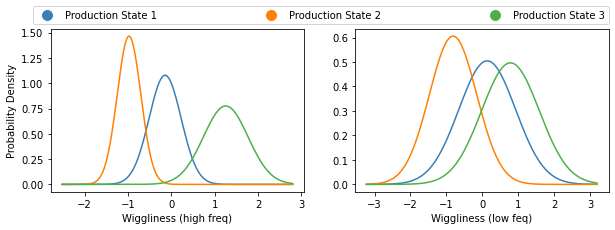

In [12]:
self = optim

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# define colors
coarse_colors = [CB_color_cycle[i+self.K[1]] for i in range(self.K[0])]
fine_colors = [CB_color_cycle[i] for i in range(self.K[1])]

K_total = self.K[1]
perc = 0.95

fig,ax = plt.subplots(1,len(self.features),figsize=(10,3))

x_labels = {"diveDuration" : "Dive Duration (s)",
            "maxDepth"     : "Maximum Depth (m)",
            "avg_bot_htv"  : "Average Bottom RHTV (rad/s)",
            "postDiveInt"  : "Post Dive Interval (seconds)",
            "w_low"        : "Wiggliness (low feq)",
            "w_high"       : "Wiggliness (high freq)",
            "delt_d"       : "Change in Depth"}

for fignum,feature in enumerate(self.features):
    
    # get bounds
    min_mu = np.min([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_mu = np.max([theta_fine[feature]['mu'] for theta_fine in self.theta])
    max_sig = np.exp(np.max([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))
    
    x = np.linspace(min_mu-3*max_sig,max_mu+3*max_sig,1000)
    
    # see if we are using a truncnorm
    a = self.features[feature]["lower_bound"]
    b = self.features[feature]["upper_bound"]
    if not a is None:
        a = np.concatenate([self.features[feature]["lower_bound"] for _ in self.theta])
    if not b is None:
        b = np.concatenate([self.features[feature]["upper_bound"] for _ in self.theta])

    # now get the y values for each x
    y0 = np.zeros((1000,K_total))

    # true ys
    mu = np.concatenate([theta_fine[feature]['mu'] for theta_fine in self.theta])
    sig = np.exp(np.concatenate([theta_fine[feature]['log_sig'] for theta_fine in self.theta]))

    for state in range(K_total):
        if (not a is None) and (not b is None):
            y0[:,state] = truncnorm.pdf(x,a=(a[state]-mu[state])/sig[state],
                                          b=(b[state]-mu[state])/sig[state],
                                          loc=mu[state],scale=sig[state])
        else:
            y0[:,state] = norm.pdf(x,mu[state],sig[state])
    
    if feature == "maxDepth":
        ax[fignum].axvline(np.log(20),color='k',linestyle='--')
        ax[fignum].axvline(np.log(5),color='k',linestyle='--')
    
    for state in range(self.K[1]):
        
        # plot distribution
        ax[fignum].plot(x,y0[:,state],
                        color=CB_color_cycle[state])
        
    # add labels
    if fignum == 0:
        ax[fignum].set_ylabel("Probability Density")

    ax[fignum].set_xlabel(x_labels[feature])
        
leg_labels = ['Production State %d'%(i+1) for i in range(self.K[1])]

legend_elements = [Line2D([0], [0], marker='o', color='w', label=leg_labels[i],
                   markerfacecolor=fine_colors[i], markersize=12) for i in range(self.K[1])]

fig.legend(handles=legend_elements,prop={'size': 10}, ncol=self.K[1], mode="expand", borderaxespad=0.,
             bbox_to_anchor=(0.1, 0.9, 0.8, .1), loc='lower left')

# Save the HMM

In [13]:
date_today = datetime.today().strftime('%Y-%m-%d')

In [14]:
file = "case_study_large_K-%d-%d_%s_%.1f_%03d" % (K[0],K[1],method,partial_E,0)

if not os.path.isdir("../params/case_study/large/"):
    os.mkdir("../params/case_study/large/")
    
if not os.path.isdir("../params/case_study/large/" + date_today):
    os.mkdir("../params/case_study/large/" + date_today)

with open("../params/case_study/large/" + date_today + "/" + file, 'wb') as f:
    pickle.dump(optim, f)

In [15]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[0]['delt_d']['mu'])
    y.append(theta[0]['delt_d']['log_sig'])
    
plt.plot(x)
plt.plot(y)

KeyError: 'delt_d'

In [ ]:
x = []
y = []
for theta in optim.theta_trace:
    x.append(theta[1]['w_low']['mu'])
    y.append(theta[1]['w_low']['log_sig'])
    
plt.plot(x)
plt.plot(y)

In [ ]:
x = []
y = []
for eta in optim.eta_trace:
    x.append(eta[0].flatten())
    #y.append(eta[1])
    
plt.plot(x)
#plt.plot(y)

In [ ]:
x = []
y = []
for eta in optim.eta_trace:
    x.append(eta[1][0].flatten())
    y.append(eta[1][1].flatten())
    
plt.plot(x)
plt.ylim([-5,5])
plt.show()

plt.plot(y)
plt.ylim([-5,5])
plt.show()

In [ ]:
date_today